# Data Science for Good: City of Los Angeles

## Problem statement
The goal is to convert a folder full of plain-text job postings into a single structured CSV file and then to use this data to:
1.  identify language that can negatively bias the pool of applicants; 
2.  improve the diversity and quality of the applicant pool; and/or 
3.  make it easier to determine which promotions are available to employees in each job class.

## A General Guide to This Notebook
This notebook in organized as the following:
* Import Libraries: All libraries required to run the notebook imports here.
* Structured Dataset Building: The methodology and code to convert raw data into a stuctured dataset for following data analysis. The final output dataframe gives us a clear possibility to all promotion path of job classes. Each row in the dataframe refers to a set of minimun requirements need to be satisfied for a particular job class title.
* Data Analysis & Stats: Explore the dataset we get from previous step, and try to see if we can get some interesting insights from it.
* Text analysis for recommandation: Here we'll try to anwser the questions in our problem statement.
* Summary & Recommendation

## Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
import re
import os
import numpy as np
from datetime import datetime
from collections  import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import math
import warnings
warnings.filterwarnings('ignore')# Don't show warnings
%matplotlib inline 

## Structured Dataset Building

### We first take a look of all data in folder "CityofLA"

In [2]:
bulletins=os.listdir("Job Bulletins/")
additional=os.listdir("Additional data/")

In [3]:
# Show the first five
bulletins[:5]

['311 DIRECTOR  9206 041814.txt',
 'ACCOUNTANT 1513 062218.txt',
 'ACCOUNTING CLERK 1223 071318.txt',
 'ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt',
 'ADMINISTRATIVE ANALYST 1590 060118.txt']

In [4]:
print(f"We have {len(bulletins)} .txt files in folder 'Job Bulletins'!")

We have 683 .txt files in folder 'Job Bulletins'!


In [5]:
additional

['job_titles.csv',
 'kaggle_data_dictionary.csv',
 'sample job class export template.csv']

#### Raw data in hands
- CityofLA/Job Bulletins: A folder that contains 683 job bulletins in text format.
- CityofLA/Additional data/sample job class export template.csv: **Looks like our final structure dataset should look something like this.**
- CityofLA/Additional data/kaggle_data_dictionary.csv: **Fields value decription of in the structure dataset.**
- CityofLA/Additional data/job_titles.csv: **List of job class titles in LA City.**
- CityofLA/Additional data/PDFs: A folder that contains job bulletins in PDF format organized by date subfolders.
- CityofLA/Additional data/job bulletins with annotations: A folder that contains some detail decriptions of job bulletins.
- CityofLA/Additional data/City Job Paths: A folder that contains 147 PDF files that decribes the promotion relationships between jobs and the type of jobs that are entry/open level.

### Output Example

In [6]:
template = pd.read_csv("Additional data/sample job class export template.csv")
print(template.shape)
template

(5, 25)


,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,...,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,...,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


In [7]:
template.columns

Index(['FILE_NAME', 'JOB_CLASS_TITLE', 'JOB_CLASS_NO', 'REQUIREMENT_SET_ID',
       'REQUIREMENT_SUBSET_ID', 'JOB_DUTIES', 'EDUCATION_YEARS', 'SCHOOL_TYPE',
       'EDUCATION_MAJOR', 'EXPERIENCE_LENGTH', 'FULL_TIME_PART_TIME',
       'EXP_JOB_CLASS_TITLE', 'EXP_JOB_CLASS_ALT_RESP',
       'EXP_JOB_CLASS_FUNCTION', 'COURSE_COUNT', 'COURSE_LENGTH',
       'COURSE_SUBJECT', 'MISC_COURSE_DETAILS', 'DRIVERS_LICENSE_REQ',
       'DRIV_LIC_TYPE', 'ADDTL_LIC', 'EXAM_TYPE', 'ENTRY_SALARY_GEN',
       'ENTRY_SALARY_DWP', 'OPEN_DATE'],
      dtype='object')

There are 25 features to be extract from the text file. Let's check the example text file "SYSTEMS ANALYST 1596 102717.txt" and see where is the information.

In [8]:
with open("Job Bulletins/SYSTEMS ANALYST 1596 102717.txt") as f:
    # Unmark to read
    #print(f.read())
    pass

Looks like a text have serveral sections with a **all-uppercase-letter heading**, most field value could be captured by searching key words, but it seems that a lot of work needs to be done in the "REQUIREMENT" section.

### Structured Dataset Building

Generally, we could use regex (re module in python) to help use extract the information we want from the text files. From the previous conclusion we see that all headings and job title in the raw text file are all uppercase letters. We could use this feature to help divide the text into subtext for more complex parsing or just search for the information we want. 

In [9]:
fail_list = []
heading = set()
# Check all files
for file in bulletins:
    with open("Job Bulletins/"+file) as f:
        try:
            #Clear all '\t', '\r', for better result visulization
            text = f.read().replace('\t','').replace('\r', '')
            lines = text.split('\n')
            while len(lines[0]) == 0:
                # Exclude empty strings
                lines.pop(0)
            # We know the first line that is not emtpy string and all uppercase letter is the job title
            # Exclude the job title to see the headings of each sections
            lines.pop(0) 
            heads = set([head for head in lines if head.isupper()])
            heading = heading.union(heads)
            
        except Exception as e:
            fail_list.append(file)

# Unmark to see
#heading

Quick check of the headings, it shows that there are slightly different expressions of the equivalent meaning, such as extra spaces at the front, extra spaces at the end, w/ or w/o plural and different vocabulary expressions.

In [10]:
fail_list

[]

Among 683 files only one file has problem opening it, which sounds accetable for now.

### Determine the patterns to extract the feature values.
According to the description in "kaggle_data_dictionary.csv", we need to extract information for **25 fields**: 

FILE_NAME, JOB_CLASS_TITLE, JOB_CLASS_NO, REQUIREMENT_SET_ID,  REQUIREMENT_SUBSET_ID, JOB_DUTIES, EDUCATION_YEARS, SCHOOL_TYPE, EDUCATION_MAJOR, EXPERIENCE_LENGTH, FULL_TIME_PART_TIME, EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION, COURSE_COUNT, COURSE_LENGTH, COURSE_SUBJECT, MISC_COURSE_DETAILS, DRIVERS_LICENSE_REQ, DRIV_LIC_TYPE, ADDTL_LIC, EXAM_TYPE, ENTRY_SALARY_GEN, ENTRY_SALARY_DWP, OPEN_DATE.

Among the above **25 fields**, there are **14 fields** extract its' values from **"REQUIREMENTS" subtext**:

REQUIREMENT_SET_ID,  REQUIREMENT_SUBSET_ID, EDUCATION_YEARS, SCHOOL_TYPE, EDUCATION_MAJOR, EXPERIENCE_LENGTH, FULL_TIME_PART_TIME, EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION, COURSE_COUNT, COURSE_LENGTH, COURSE_SUBJECT, MISC_COURSE_DETAILS.

And the **14 fields** related to REQUIRMENTS could be classified into three kinds: 
* **Education background:** EDUCATION_YEARS, SCHOOL_TYPE, EDUCATION_MAJOR.
* **Previous job experience:** EXPERIENCE_LENGTH, FULL_TIME_PART_TIME, EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION.
* **Coueses Taken:** COURSE_COUNT, COURSE_LENGTH, COURSE_SUBJECT, MISC_COURSE_DETAILS.

Due to the difficulty in extracting REQUIREMENTS related fields,there are serveral funtions written to help parse the subtext "REQUIREMENTS". **These functions are closely coupled with the main code**, they **utilize global variables df and i, which stands for the final output dataframe (a structed dataset) and the current row index of the dataframe.**

### And the following code blocks is organized as:
#### Functions that support parsing the REQUIREMENTS text
- parse_course(text): Takes in a string and write COURSE_COUNT, COURSE_LENGTH, COURSE_SUBJECT and MISC_COURSE_DETAILS to the dataframe.
- length_in_year(text): Takes in a string and returns a float that indicates the length in years. It is used in parse_job(text) and parse_edu(text).
- def parse_job(text): Takes in a string and write EXPERIENCE_LENGTH, FULL_TIME_PART_TIME, EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP and EXP_JOB_CLASS_FUNCTION to the dataframe.
- parse_edu(text): Takes in a string and write EDUCATION_YEARS, SCHOOL_TYPE and EDUCATION_MAJOR to the dataframe.
- parse_check(text): Takes in a string and returns a int that indicates whay which parse type function should be called to parse the text content. Is used in parse_helper().
- parse_helper(text): Takes in a string and select a parse type function, either parse_edu(), parse_job() or parse_course() should be called to parse the text. Separate the text into piecies if multi types are detected.
- parse_sub_req(text, is_and): Takes in a string text and boolean (indicates conjunction correlation with the previous item) and devide a requirement set into sub requirement sets. Determine the conjunciton (and/or) realtionship between sub sets. Assgin REQUIREMENT_SUBSET_ID value to dataframe.
- parse_req(text): Takes in a string text and divide it into requirement sets and determine the parsing sequence of the sets, assign REQUIREMENT_SET_ID value to the dataframe.

#### Main code
The code that generate a dataframe (variable name: df), the final structured data set for data analysis. Other field value is that is not in the REQUIREMENT text is determined here.

Functions that support parsing the REQUIREMENTS text. (These functions need to be run before running the main code block!)

In [11]:
def parse_course(text):
    '''
    Takes in a string text and doesn't return any value. Complete the following tasks:
    1. Get COURSE_COUNT value by calling length_in_year()
    2. Get COURSE_LENGTH value
    3. Get COURSE_SUBJECT value
    4. Get MISC_COURSE_DETAILS value
    '''

    global df
    global i
    
    # Get COURSE_COUNT
    count_dict = {'one':1, 'two':2,'three':3, 'four':4, 'five':5,
                 'six':6, 'seven':7 , 'eight':8, 'nine':9, 'ten':10}
    count = re.compile(r"(one|two|three|four|five|six|seven|eight|nine|ten) course",re.I).search(text)
    if count:
        df.at[i,'COURSE_COUNT'] = count_dict[count.group(1).lower()]
    else:
        count = re.compile(r"(\d+) course",re.I).search(text)
        if count:
            df.at[i,'COURSE_COUNT'] = count.group(1)
            
    # Get COURSE_LENGTH
    semester = re.compile(r" semesters?\W",re.I).search(text)
    quarter  = re.compile(r" quarters?\W",re.I).search(text)
    course_lenth = ''
    if quarter:
        quarter = re.compile(r"(one|two|three|four|five|six|seven|eight|nine|ten) quarter",re.I).search(text)
        if quarter:
            course_lenth = str(count_dict[quarter.group(1).lower()])+'Q'
        else:
            quarter = re.compile(r"(\d+) quarters?",re.I).search(text)
            if quarter:
                 course_lenth = str(quarter.group(1))+'Q'
    if semester:
        semester = re.compile(r"(one|two|three|four|five|six|seven|eight|nine|ten) semester",re.I).search(text)
        if semester:
            course_lenth += '|'+str(count_dict[semester.group(1).lower()])+'S'
        else:
            semester = re.compile(r"(\d+) semesters?",re.I).search(text)
            if semester:
                 course_lenth += '|'+str(semester.group(1))+'S'
                    
    df.at[i,'COURSE_LENGTH'] = course_lenth
    
    # Get COURSE_SUBJECT
    # Statements for requirement substitution will put into MISC_COURSE_DETAILS
    check1 = re.compile(r"course\w* is equivalent to").search(text)
    if check1 or "substitute" in text:
        course_text = re.compile(r"\s(\w\. )?([\w, ()'/\.-]+)",re.I).search(text)
        if course_text:
            df.at[i,'MISC_COURSE_DETAILS'] = course_text.group(2)   
            return
    
   
    
    # Keep updating possible endings
    course_text = text.replace(', from', '.').replace(' from', '.').replace(', and', '.').replace('; or', '.')
    course_text = course_text.replace(' and/or ', ', ').replace(', or ',' or ').replace(' or ', ', ') 
    # Refining text correlated to course subject
    with_text = re.compile(r" with .+").search(course_text)
    if with_text:
        course_text = with_text.group()
    course1 = re.compile(r" follow[\w ]+:\s*([\w\(\); ,'-]+)").search(course_text)
    course2 = re.compile(r" in ([\w\(\) ,'-]+)").search(course_text)
    course3 = re.compile(r"units of ([\w\(\) ,'-]+?) course").search(course_text)

    if course1:
        course_text = course1.group(1).replace('; and ', ', ').replace('; ', ', ')
    elif course2:
        course_text = course2.group(1)
    elif course3:
        course3 = re.compile(r" units of ([\w\(\) ,'-]+?) course").findall(course_text)
        course_list = []
        for x in course3:
            course_list += x.split(", ")
        df.at[i,'COURSE_SUBJECT'] = "|".join([c.upper() for c in course_list])
        return
    
    else:
        course_text = re.compile(r"\s(\w\. )?([\w, ()'/\.-]+)",re.I).search(text)
        if course_text:
            df.at[i,'MISC_COURSE_DETAILS'] = course_text.group(2)  
        else:
            print("ERROR! Need a better course subject pattern! File:" ,file)
            print("TEXT:", text)
        return
    
    # Remove strings inside paranthesis
    while '(' in course_text and ')' in course_text :
        course_text = course_text[:course_text.find('(')-1] + course_text[course_text.find(')')+1:]
    
    #subject = re.compile(r"([A-Z][a-z]+( [aA]nd| [Oo]f)?( [A-Z][a-z]+)*)").findall(text)
    subject = re.compile(r"([A-Z][a-z']+(( [aA]nd\W| [Oo]f\W)? ?[A-Z]+[a-z']*)*)").findall(course_text)

    subject_list = set() #to exclude duplicated records       
    for x, y, z in subject:#two parenthesis indicates two group, but we only want the first one
        if 'Los ' not in x:
            subject_list.add(x)

    if len(subject_list) != 0:
        subject_list = list(subject_list)
        df.at[i,'COURSE_SUBJECT'] = subject_list[0].upper() 
        for ind in range(1,len(subject_list)):
            df.at[i,'COURSE_SUBJECT'] += '|'+ subject_list[ind].upper()
    else:
        subject_list = course_text.split(', ')
        df.at[i,'COURSE_SUBJECT'] = subject_list[0]
        for ind in range(1,len(subject_list)):
            df.at[i,'COURSE_SUBJECT'] += '|' + subject_list[ind]
    

In [12]:
def length_in_year(text):
    '''
    Takes in a string text, Returns a float that indicates the length of period in year, returns None if not found.
    '''

    num_word = {'one':1, 'two':2,'three':3, 'four':4, 'five':5,'six':6, 'seven':7 , 'eight':8, 'nine':9, 'ten':10,
                'eleven':11,'twelve':12,'thirteen':13,'fourteen':14, 'fifteen':15, 'sixteen':16,'seventeen':17,
                'eighteen':18, 'nineteen':19,'twenty':20,'thirty':30} 
    
    # Try find word expression of year length first
    year = re.compile(r"(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty)[\w\(\) -]*year",re.I).search(text)
    if year:
        return float(num_word[year.group(1).lower()])
    else:
        # Try find digit expression of year
        year = re.compile(r"(\d+(\.\d)?)[\w ]*year",re.I).search(text)
        if year:
            return float(year.group(1))
        else:
            # Try find digit expression of month
            month = re.compile(r"(\d+(\.\d)?)[\w ]*month",re.I).search(text)
            if month:
                return float(month.group(1))/12
            else:
                # Try find word expression of month
                month = re.compile(r"(one|two|three|four|five|six|seven|eight|nine|ten|eighteen|thirty)[\w\(\) -]*month",re.I).search(text)
                if month:
                    return float(num_word[month.group(1).lower()])/12
    
    return None

In [13]:
#Import the job title list needed for "EXP_JOB_CLASS_TITLE".
job_title = pd.read_csv("Additional data/job_titles.csv", header=None)
job_titles = set(job_title[0])

# General role name
job_alt_class = ['accountant','advisor','administrator','advocate','agent','aide','analyst','aquarist','architect',
                'archivist','assistant', 'associate','attendant','auditor','apprentice','biologist','blacksmith','boilermaker',
                'buyer', 'captain','caretaker','chemist','chief','cleaner','commander','controller','coordinator',
                'criminalist','curator','cabinetmaker','custodian','contractor','designer','detective','director', 'dispatcher','driver','educator',
                'electrician','engineer','estimator','examiner','expert','fabricator','finisher','firefighter', 'gardener',
                'geologist','guide','helper','hydrographer', 'hygienist','inspector','investigator', 'keeper','laborer',
                'layer','librarian', 'lieutenant','locksmith','machinist','masonry','manager','mate','mechanic','microbiologist',
                 'nurse','officer','operator','painter','photographer','pilot', 'pipefitter', 'planner','plumber', 'police',
                'poster', 'preparator', 'programmer', 'provider', 'ranger',  'reader','registrar', 'repairer',
                'representative','roofer', 'secretary','sergeant', 'setter','specialist', 'starter','storekeeper',
                'superintendent','supervisor','surgeon','technician','tester','trainee','welder','wharfinger','worker']

def parse_job(text):
    '''
    Takes in a string text, No return value. Complete the following tasks:
    1. Get EXPERIENCE_LENGTH value by calling length_in_year()
    2. Get FULL_TIME_PART_TIME value: search for keywords like "full-time" or "part-time"
    3. Get EXP_JOB_CLASS_TITLE value: search for proper nouns that matches the job title in "job_titles.csv"
    4. Get EXP_JOB_CLASS_ALT_RESP value: search for proper nouns that is NOT in "job_titles.csv", or non-proper noun format forms.
    5. Get EXP_JOB_CLASS_FUNCTION value: search for strings related to job function descriptions like 
       e.g., involved in the installation, modification, maintenance and repair of air conditioning,.....
    
    The relationship of getting values between EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION:
    
    1. Generally this funciton first search for proper nouns that matches titles in the LA city "job_titles.csv", 
    if success, assign the matches to EXP_JOB_CLASS_TITLE with all UPPERCASE letters, here we assume for a single subitem 
    statement it is clear enough, so stop searching for alternative job title expression (EXP_JOB_CLASS_ALT_RESP) and
    job function descriptions (EXP_JOB_CLASS_FUNCTION).
    
    2. If it can't find any EXP_JOB_CLASS_TITLE value, it will then try get EXP_JOB_CLASS_ALT_RESP
    For EXP_JOB_CLASS_ALT_RESP, it first find proper noun format strings in particular positions, if NOT found, then 
    it tries to find lowercase letters in the correct position. 
    
    3. If it can't find any EXP_JOB_CLASS_TITLE and EXP_JOB_CLASS_ALT_RESP values, it will also try get 
    EXP_JOB_CLASS_FUNCTION by seaching a particalur pattern expression.    
    
    '''
    global df
    global i

    # Get EXPERIENCE_LENGTH value
    if length_in_year(text):
        df.at[i,'EXPERIENCE_LENGTH'] = length_in_year(text)
        
    # Get FULL_TIME_PART_TIME value. 
    ftpt = re.compile(r"(part[- ]time|full[- ]time)",re.I).search(text)
    if ftpt:
        if "part" in ftpt.group(1).lower():
            df.at[i,'FULL_TIME_PART_TIME'] = "PART-TIME"
        else:
            df.at[i,'FULL_TIME_PART_TIME'] = "FULL-TIME"
        

    # Get EXP_JOB_CLASS_TITLE, EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION value
    # Words that likely to indicate job title ends. (Keep updating)
    exp_text = text.replace(' with ', '.').replace(' or in ', '.').replace(' in ', '.').replace(' or an ', ', ')
    exp_text = exp_text.replace(' perform', '.').replace(' engaged', '.').replace(' within ', '.')
    exp_text = exp_text.replace('; and','.').replace('; or','.').replace('City of Los Angeles','city')

    # Refine the text
    exp_regex1 = re.compile(r" at the level of (an? )?([\w;,#/\(\) -]+)", re.I).search(exp_text)
    exp_regex2 =re.compile(r" as (an? )?([\w;,#/\(\) -]+)", re.I).search(exp_text)

    if exp_regex1:
        exp_text = exp_regex1.group(2)

    elif exp_regex2:
        exp_text = exp_regex2.group(2)
  
    else:
        # If no job title pattern match, get job function   
        job_func1 = re.compile(r" (in|in:) ([\w,\(\)#/ -]+)[^; or\s*][^; and\s*]", re.I).search(text)
        job_func2 = re.compile(r" (at|with) ([\w,\(\)#/ -]+)[^; or\s*][^; and\s*]", re.I).search(text)
        job_func3 = re.compile(r"([a-z]+ing [\w,\(\)#/ -]+)[^; or\s*][^; and\s*]", re.I).search(text)
        if job_func1:
            job_func_text = job_func1.group(2)
        elif job_func2:
            job_func_text = job_func2.group(2)
        elif job_func3:
            job_func_text = job_func3.group(1)
        else:
            # Grab the whole sentence
            fulltext = re.compile(r"\n(\w\W) ([\w, ()'/-]+)",re.I).search(text)
            if fulltext:# e.g, 1. either: or 2. One of the following:,....
                df.at[i,'EXP_JOB_CLASS_FUNCTION'] = re.compile(r"\n(\w\W) ([\w, ()'/-]+)",re.I).search(text).group(2)
            else:
                while text[0] == '\n' or text[0] == ' ':
                    text = text[1:]
                df.at[i,'EXP_JOB_CLASS_FUNCTION'] = text
            return
            
        # If any job_func match, remove white spaces in front, assign value into dataframe
        while job_func_text[0] == ' ':
            job_func_text = job_func_text[1:]

        df.at[i,'EXP_JOB_CLASS_FUNCTION'] = job_func_text
        return

    # If any exp_regex match, di the following
    # Try grab proper noun format, e.g, "Maintenance and Construction Helper".
    exp_title = re.compile("((Pre-)?[A-Z][a-z']+( [aA]nd\W| [Oo]f\W)?( ?(Pre-)?[A-Z]+[a-z']*)*)").findall(exp_text)
    
    title_list = set()
    for x,y,z,w,q in exp_title:

        title_list.add(x)
    
    job_alt_list = set() # Holds possible alternative job titles if any
    
    if len(title_list) != 0:
        assig_val = [] # this hold internal city job titles if any
        for _ in title_list:
            if _[-1] in ['I','X','V']: 
            # If it match something like Axxxx II, we assume it will be in the list. e.g. Assistant Inspector IV
                assig_val.append(_.upper())   
            # Check if it's in Internal City job class
            elif _.upper() in job_titles: 
                assig_val.append(_.upper())
            else:
                # If the last word match in alternative job calss, add it in
                if _.split()[-1].lower() in job_alt_class:
                    job_alt_list.add(_)
        
        # Add all job class title match to EXP_JOB_CLASS_TITLE
        if len(assig_val) != 0:    
            df.at[i,'EXP_JOB_CLASS_TITLE'] = '|'.join(assig_val)


    # If no proper noun found, try grab normal noun and regard it as an alternative title
    job_atl_text = exp_text.replace(', or ', ', ').replace(' or ', ', ').replace(' and/or ', ', ').replace(', and', ', ')


    # Check if the last word matches a role name
    if len(job_alt_list)==0:
        for ele in job_atl_text.split(', '):
            if ele.split(' ')[-1] in job_alt_class: 
                job_alt_list.add(ele)

    if len(job_alt_list) != 0:
        df.at[i,'EXP_JOB_CLASS_ALT_RESP'] = '|'.join(list(job_alt_list))

    # Get EXP_JOB_CLASS_FUNCTION, the same as above
    # If no job title pattern match, get job function   
    job_func1 = re.compile(r" (in|in:) ([\w,;\(\)#/ -]+)[^; or\s*][^; and\s*]", re.I).search(text)
    job_func2 = re.compile(r" (at|with) ([\w,\(\)#/; -]+)[^; or\s*][^; and\s*]", re.I).search(text)
    job_func3 = re.compile(r"[a-z]+ing ([\w,#\(\)/; -]+)[^; or\s*][^; and\s*]", re.I).search(text)
    if job_func1:
        job_func_text = job_func1.group(2)
    elif job_func2:
        job_func_text = job_func2.group(2)
    elif job_func3:
        job_func_text = job_func3.group(1)
    else:
        if " as a" in "text":
            return # Just a position with no job function description 
            
        # Grab the whole sentence
        fulltext = re.compile(r"\n(\w\W) ([\w, ()'/-]+)",re.I).search(text)
        if fulltext:# e.g, 1. either: or 2. One of the following:,....
            fulltext = fulltext.group(2)
            while fulltext[0] == '\n' or text[0] == ' ':
                fulltext = fulltext[1:]
            df.at[i,'EXP_JOB_CLASS_FUNCTION'] = fulltext
        else:
            while text[0] == '\n' or text[0] == ' ':
                text = text[1:]
            df.at[i,'EXP_JOB_CLASS_FUNCTION'] = text
        return

In [14]:
def parse_edu(text):
    '''
    Takes in a string text and doesn't return any value. Complete the following tasks:
    1. Get EDUCATION_YEARS value by calling length_in_year()
    2. Get EDUCATION_MAJOR value
    3. Get EDUCATION_MAJOR value
    '''
    global df
    global i
    
    #print("parse_edu:", text)
    # Get EDUCATION_YEARS value
    if length_in_year(text):
        df.at[i,'EDUCATION_YEARS'] = length_in_year(text)
        
    # Get SCHOOL_TYPE value of either COLLEGE OR UNIVERSITY, HIGH SCHOOL, APPRENTICESHIP
    if 'apprentice' in text.lower():
        df.at[i,'SCHOOL_TYPE'] = 'APPRENTICESHIP'
        
    elif 'high school' in text.lower():
        df.at[i,'SCHOOL_TYPE'] = 'HIGH SCHOOL'
    else:
        df.at[i,'SCHOOL_TYPE'] = 'COLLEGE OR UNIVERSITY'
        
    # Get EDUCATION_MAJOR value
    # Formating text content and use key words to indicates list of major option ends (keep updating) 
    major_text = text.replace(' from', '.').replace(' with', '.').replace(', including', '.').replace('upon ', '.')
    major_text = re.compile(r"(degree)? in (an? )?([\w/,\(\): &-]+)").search(major_text)
    
    if major_text:
        major_text = major_text.group(3)
        # Handle expression like "in the following major: CS; CE; SE." or "Major in the following areas: \nCS \nCE \nSE"
        if ':' in text:
            # Replace '\n' and ';' after ':' with ', ' 
            col_pos = text.find(":")
            major_text = text[col_pos:].replace('\n', ', ').replace('; ', ', ')
            # Remove white spaces in the front
            while ' ' in major_text[0]:
                major_text = major_text[1:]

        # Remove contents in the paranthesis
        while '(' in major_text and ')' in major_text:
            major_text = major_text[:major_text.find('(')-1] + major_text[major_text.find(')')+1:]

        # Separating marks (keep updating)
        major_text =  major_text.replace(', or ', ', ').replace(' or ', ', ').replace(' and/or ', ', ').replace(', and', ', ')
        major_list = major_text.split(', ')
        # Remove emtpy string
        while '' in major_list:
            major_list.remove('')
        df.at[i,'EDUCATION_MAJOR'] = '|'.join([m.upper() for m in major_list if "related" not in m and " a " not in m ])        


In [15]:
def parse_check(text):
    '''
    Takes in a string text and use regex to determine what basic type of the string is.
    Basic type includes either of education, job expereince, course, or multi-type.
    Return a int as a flag that indicates what basic type is the text.
    flag value definition:
    0: unknown structure, most likely be job funtion desciptions or course misc details, or non of the basic types.
    1: information regard to education backgroud only.
    2: information regard to previous job experience only.
    3: information regard to course information only.
    4: Double types information detected.
    : Triple types information detected.
    
    '''
    # Initialize default to unkown type
    flag = 0 
    count = 0 # match type count
    
    # Regex rules for determining basic type of statements
    edu1 = re.compile(r"degree from [\w. -]*college", re.I).search(text) 
    edu2 = re.compile(r"graduation from [\w. -]*(college|high school)", re.I).search(text) 
    edu3 = re.compile(r"completion [\w' -]*apprenticeship", re.I).search(text)
    edu4 = re.compile(r"(bachelor's|master's|Ph\.D\.) degree in", re.I).search(text)
    job1 = re.compile(r"(full-time|part-time|paid) [\w\(\)' -]*experience",re.I).search(text)
    job2 = re.compile(r"current status as an? [\w\(\)' -]",re.I).search(text)
    cour1 = re.compile(r" semester", re.I).search(text)
    cour2 = re.compile(r" quarter", re.I).search(text)
    cour3 = re.compile(r"completion [\w' -]*course",re.I).search(text)
    
    if edu1 or edu2 or edu3 or edu4:
        count += 1
        flag = 1
    if job1 or job2:
        count += 1
        flag = 2
    if (cour1 and cour2) or cour3:
        count += 1
        flag = 3
        
    if count == 2:
        flag = 4
        
    if count == 3:
        flag = 5
    
    return flag
    

In [16]:
def parse_helper(text):
    '''
    Takes in a string text, No return value. Complete the following tasks: 
    1. Call parse_check() to help select the next further parsing function.
    2. If multiple types are found in the text, try to seperate the text by some key words. 
        For exmaple: Graduation in a four-year college and two year experience as a data scienctis.  
        There are two type information in the text, education background and previous job experience requirements.
        We could seperate it by "and" where left side is education background information and the right side is 
        previous job experience information, then call parse_edu() on left and parse_job() on the right.
    3. Assign MISC_COURSE_DETAILS and EXP_JOB_CLASS_FUNCTION value if some conditions are met.
    '''
    global df
    global i
    
    check_flag = parse_check(text)
    # Unknow structure
    if check_flag == 0:
        if 'course' in text.lower() or 'program' in text.lower() or "certificate" in text.lower():
            df.at[i,'MISC_COURSE_DETAILS'] = re.compile(r"\s(\w\. )?([\w, ()'/-]+)",re.I).search(text).group(2)
            return
        else:

            main_item = re.compile(r"\n\s*\d\W").search(text)        
            if main_item == None:# e.g, 1. either: or 2. One of the following:,....
                df.at[i,'EXP_JOB_CLASS_FUNCTION'] = re.compile(r"\s*\n(\w\W)? ?([\w, ()'/-]+)",re.I).search(text).group(2)
                #print("df.at[i,'EXP_JOB_CLASS_FUNCTION']:", df.at[i,'EXP_JOB_CLASS_FUNCTION'])
            return
    if check_flag == 1:
        parse_edu(text)
        
    elif check_flag == 2:
        parse_job(text)
    
    elif check_flag == 3:
        parse_course(text)
        
    else:
        # Try to separate the text by some key words to make each pieces just a single type
        left = text
        right = ''
        
        if check_flag == 4:
            pivot_words = ['completion','AND', '; and',', and ',', which',' with ','including ',' and ', 'graduation', 'Both']

            for p in pivot_words:
                if p in text:
                    left = text[:text.find(p)]
                    right = text[text.find(p):]

                if parse_check(left) != 4 and parse_check(right) != 4:
                    parse_helper(left)
                    parse_helper(right)
                    return

            print("Double type expression, NEED TO ADD A NEW PIVOT! File:", file)
            print("TEXT:", text)
            
        else:
            left = text
            right = ''
            pivot_words = ['; and', ' and ']
            for p in pivot_words:
                if p in text:
                    left = text[:text.find(p)]
                    right = text[text.find(p):]
                if parse_check(left) != 5 and parse_check(right) != 5:
                    parse_helper(left)
                    parse_helper(right)
                    return
            
            print("Triple type expression, NEED TO ADD A NEW PIVOT! File:", file)
            print("TEXT:", text)

In [17]:
def parse_sub_req(text, is_and):
    '''
    Takes in a string text and boolean (indicates conjunction correlation with the previous item), 
    and Complete the following tasks:
    1. Assgin REQUIREMENT_SUBSET_ID value.
    2. Divide the text into sub bullet items e.g., a. some statements b. some statements c...., etc.
    3. Check the conjunction realationship between the sub bullet items. e.g., a. and b.; a. or b.
    and then determine whether generates a new row or not. 
    For example, a. and b. stands for multi requiements need to satisfy, so one row generated. 
    On the other hand, a. or b. stands for optional requirement need to satisfy, so two rows are generated.
      
    '''
    global df
    global i
    
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    subset_id_dict = { k:v for (k, v) in enumerate(alphabet)} #{0:'A', 1:'B', ....,etc.}
    
    # Find all position of the subitems
    subitems = re.compile(r"(\s[a-z]\. |\n[a-z]\W )",re.I).finditer(text) # e.g., \A., \na., \na), 
    items = []
    for m in subitems:
        items.append(m.start()) # record the position of a., b.,c. in the text.
        
    if len(items) < 2:#text only have one subitem 'a.', then parse the whole text

        if is_and: # If the correlation with the previous parse item is AND, no need to overwrite the previous value.
            parse_helper(text)
        else:
            df.at[i,'REQUIREMENT_SUBSET_ID'] = 'A'
            parse_helper(text)
        
    else:

        # Split the text into subtexts 1....; a....; b....; c..., etc.
        subtext = [text[:items[0]]] # 1.....; 
        for x in range(len(items)-1):
            subtext.append(text[items[x]:items[x+1]])
        subtext.append(text[items[-1]:])
        
        # Check conjunction relationship
        is_and = False
        if " and" in subtext[0][-6:]:
            is_and = True
                    
        parse_helper(subtext.pop(0)) # Parse 1....; first
        row_copy = df.loc[i].copy() # Make a copy of the shared data
        
        subsetid_ind = 0
        df.at[i,'REQUIREMENT_SUBSET_ID'] = subset_id_dict[subsetid_ind] # 0 for 'A', 1 for 'B'
        while len(subtext) != 0:
            nextitem = subtext.pop(0)
            if is_and == False:
                parse_helper(nextitem)
                if len(subtext) != 0:
                    i+=1
                    subsetid_ind+=1
                    df.loc[i] = row_copy
                    df.at[i,'REQUIREMENT_SUBSET_ID'] = subset_id_dict[subsetid_ind]
                    if ' and' in nextitem[-6:]:
                        is_and = True
            else:
                parse_helper(nextitem)
                if ' or' in nextitem[-6:]:
                    is_and = False


In [18]:
def parse_req(text):
    '''
    Takes in a string text and doesn't return any value. Complete the following tasks:
    1. Assign REQUIREMENT_SET_ID value.
    2. Divide the text into main bullet items e.g., 1. some statements 2. some statements 3. ...,etc.
    3. Check the conjunction realationship between the bullet items. e.g., 1. and 2.; 1. or 2.
    and then determine the further parsing sequence of the bullet items. 
        
        For example, if the text structure looks somthing like this: 
        1. Master degree in either: 
        a. Computer Science; or 
        b. Computer Engineering; or 
        c. Software Engineering; and
        2. Two years experience as a Data Scientist.

        Then the final output should generate three rows: 
        1A: Master degree in CS plus 2 year experience as a DS
        1B: Master degree in CE plus 2 year experience as a DS
        1C: Master degree in SE plus 2 year experience as a DS
        
        Where information specified in #1 and #2 should all be included in #A, #B and #C. Hence, we parse #2 first, 
        and then copy all the information on the current row of the dataframe, then parse #1. Then when parsing each 
        subitem #A, #B and #C, we copy that information to every new generated row.
    
    On the other hand, if the structure looks somthing like this:
        1. Two years experience as a Data Scientist.
        1. Master degree in either: 
        a. Computer Science; or 
        b. Computer Engineering; or 
        c. Software Engineering; and
        
        The output should be the same, so instead, we parse #1 first, then #2.
    
    If no subitems in the text, we only need to parse the main items by original order. Generate a new row if the
    realtion is "or". If subitems have an 'and' relationship then parse it by original order as well.
    
    In brief, always parse the main item first that has subitems with "or" relationship.
    The conjunction relationship defualt will be 'AND' if not specified.
    
    '''
    global df
    global i
    
    row_count = 0
    is_and = False
    
    # If there is only one requirement, assign it as 1A
    if '\n1.' not in text:

        df.at[i,'REQUIREMENT_SET_ID'] = 1 
        if '\na.' not in text.lower() or ' a.' not in text.lower():
            df.at[i,'REQUIREMENT_SUBSET_ID'] = 'A'
            parse_helper(text) 
        else:
            pass
            parse_sub_req(text, False) # This funciton handle subitems' relationship
    else:
        # Find the position of the number. e.g., 1, 2, 3, ..., etc.
        numlist = re.compile(r'\n\d\W').finditer(text)
        items = []
        for m in numlist:
            items.append(m.start())
        
        #  If there is only one main requirement, do subitem parsing. 
        if len(items) < 2: 
            df.at[i,'REQUIREMENT_SET_ID'] = 1
            parse_sub_req(text, False)
            
        else:
            # Split the text into subtexts e.g, 1. a...b...c.. 2. a...b..c.. 3. ...
            subtext = []
            for x in range(len(items)-1):
                subtext.append(text[items[x]:items[x+1]])
            subtext.append(text[items[-1]:])
            
            row_copy = df.loc[i].copy() # if a new row is generated we want values of other fields to be copied over
            setid = 1
            
            subitem_cnt = 1
            is_and = False
            while len(subtext) != 0:
                nextitem = subtext.pop(0)
                if is_and == False:
                    df.loc[i] = row_copy
                    df.at[i,'REQUIREMENT_SET_ID'] = setid
                    parse_sub_req(nextitem, is_and)
                    if " or" not in nextitem[-6:]:
                        is_and = True
                    else:
                        i+=1
                        setid+=1
                    subitem_cnt = len(re.compile(r"(\s[a-z]\. |\n[a-z]\W )",re.I).findall(nextitem))
                    if subitem_cnt == 0: subitem_cnt = 1
                        
                else:
                    k = 0
                    while k < subitem_cnt:
                        parse_sub_req(nextitem, is_and)
                        i-=1
                        k+=1
                    i+=subitem_cnt
                    if " or" in nextitem[-6:]:
                        is_and = False
                        i+=1
                        setid+=1
                        

#### Main code

In [19]:
# Initializations, df and i are global variables for supporting funcitons
df = pd.DataFrame() 
i = 0 # Row index of the dataframe
k = 0

# Debugging use. Fields that are not allowable of null values.
fail_list = set() # unexpected issues during file processing goes here
fail_job_title = set() # files that fails to match JOB_CLASS_TITLE regex goes here
fail_class_code = set() # files that fails to match JOB_CLASS_NO regex goes here
fail_duty = set() # files that fails to match JOB_DUTIES regex goes here
fail_exam = set() # files that fails to match EXAM_TYPE regex goes here
fail_salary = set() # files that fails to match ENTRY_SALARY_GEN regex goes here
fail_req = set() # files that fails parse requiement text goes here

# Open and read every text file under the bulletin directory
for file in bulletins:
    with open("Job Bulletins/"+file,encoding="ISO-8859-1") as f:
        try:
            # Clear all '\t', '\r', for better result visulization
            text = f.read().replace('\t',' ').replace('\r', '')
            
            # Get FILE_NAME
            df.at[i,'FILE_NAME'] = file
            
            # Get JOB_CLASS_TITLE
            # e.g, Grab the first line of words appear in the text that start with a capital letter
            job_title = re.compile(r"(CAMPUS INTERVIEWS ONLY\s*)?([A-Z0-9][\w'-]+( [\w'-]+)*)").search(text)
            if job_title:
                df.at[i,'JOB_CLASS_TITLE'] = ' '.join([w.capitalize() for w in job_title.group(2).lower().split(' ')])
            else:
                fail_job_title.add(file)
            
            # Get JOB_CLASS_NO
            # e.g, Class Code: 0000
            class_no = re.compile(r"\sClass *Code:\s*([0-9]{4})", re.I).search(text)
            if class_no:
                df.at[i,'JOB_CLASS_NO'] = class_no.group(1)
            else:
                fail_class_code.add(file)
                
            # Get JOB_DUTIES
            # e.g, DUTIES..some string between...\n
            duty = re.compile(r"\n\s*DUT[A-Z ]+\s+(.+)\n").search(text)
            if duty:
                df.at[i,'JOB_DUTIES'] = duty.group(1)
            else:
                fail_duty.add(file)
            
            # Get DRIVERS_LICENSE_REQ: 'R' for required, 'P' for may required, leave it None if not mentioned
            driver_req = re.compile(r"valid [\w' /()]*driver('s|s') license", re.I).search(text)
            driver_may = re.compile(r"may require [\w' /()]*driver('s|s') license", re.I).search(text)
            if driver_req: #driver_req patter covers driver_may
                if driver_may:
                    df.at[i,'DRIVERS_LICENSE_REQ'] = 'P'
                else:
                    df.at[i,'DRIVERS_LICENSE_REQ'] = 'R'

            # Get DRIV_LIC_TYPE
            # Narrow down our target, scrape a smaller piece of text first
            driver_text = re.compile(r"\sclass([\w' /(),]*)driver", re.I).search(text)
            if driver_text:
                # In the narrow down text, find all capital letters that does not ajacent to a word character
                # e.g, A, B, or C, "A", (B), etc...
                driv_type_list = set()
                driv_type = re.compile(r"[^w]([A-Z])[^\w]").findall(driver_text.group(1))
                for m in driv_type:
                    driv_type_list.add(m)
                # Assign all elements in the list to dataframe
                driv_type_list = list(driv_type_list)
                if len(driv_type_list) != 0:
                    df.at[i,'DRIV_LIC_TYPE'] = driv_type_list[0]
                    for x in range(1,len(driv_type_list)):
                        df.at[i,'DRIV_LIC_TYPE'] += '|' + driv_type_list[x]
                                    
            # Get ADDTL_LIC
            # Find all proper nouns follow with "license". e,g. "PE license", "Professional Engineer license", etc.
            addtl = re.compile(r"([A-Z]+([a-z']+|[A-Z]+)( and| or| and/or)?( [A-Z]+[a-z']*)*) [Ll]icense\W").findall(text)
            addtl_list = set() # Exclude duplicates
            
            # This list come afterwards, exclude result which doesn't seem like a "real" license
            bad_match = ['California', 'Special', 'This', 'The' ] 
  
            for m,n,o,p in addtl:
                # Exclude driver's license and bad matches
                if ("Driver" not in m) and (m not in bad_match):
                    # Accept some thing like "Rubber Tired Tractor B Operator's license" 
                    # but not "Class A" or "California Class B" license
                    if m[:5] != "Class" and m[:16] != "California Class":
                        addtl_list.add(m)
            
            addtl_list = list(addtl_list)
            if len(addtl_list) != 0:
                df.at[i,'ADDTL_LIC'] = addtl_list[0]
                for x in range(1,len(addtl_list)):
                    df.at[i,'ADDTL_LIC'] += "|" + addtl_list[x]
            
            # Get EXAM_TYPE, value should be either: OPEN, INT_DEPT_PROM, DEPT_PROM, OPEN_INT_PROM
            exam_type1 = re.compile(r"INTERDEPARTMENTAL PROMOTIONAL AND (AN )?OPEN COMPETITI?VE BASIS").search(text)
            exam_type2 = re.compile(r"INTERDEPART?MENTAL PROMOTIONAL BASIS").search(text)
            exam_type3 = re.compile(r"OPEN COMPETITIVE BASIS").search(text)
            exam_type4 = re.compile(r" DEPARTMENTAL ").search(text)
            if exam_type1 != None:
                df.at[i,'EXAM_TYPE'] = 'OPEN_INT_PROM'    
            elif exam_type2 != None:
                df.at[i,'EXAM_TYPE'] = 'INT_DEPT_PROM'
            elif exam_type3 != None:
                df.at[i,'EXAM_TYPE'] = 'OPEN'
            elif exam_type4 != None:
                df.at[i,'EXAM_TYPE'] = 'DEPT_PROM'
            else:
                fail_exam.add(file)
           
            
            #Get ENTRY_SALARY_GEN & ENTRY_SALARY_DWP:
            '''
            1. Scrape text patter. e.g., ANNUAL SALARY\n $68,611 to $100,307 ...to four consecutive capital letters
            2. From the scraped text, try find salary range pattern first. e.g., $68,611 to $100,307
            3. If no match found, then try get flat-rated. e.g., $100,829 (flat-rated)
            4. If multi salaries are specified, always grab the first one. e.g., $60,489 to $88,468 and $71,451 to $104,462
            5. Assume normal salary always comes before DWP salary if both are specified.
            6. If only DWP salary is specified than it will be the value of both ENTRY_SALARY_GEN & ENTRY_SALARY_DWP.
            
            *** we are going to ACCEPT typo expression like "ANNUALSALARY" here!***
            '''
            # Narrow down our target value position first
            salary = re.compile(r"ANNUAL\s*SALARY\s+(.|\n)+?[A-Z]{4}").search(text)
            if salary:
                sal_text = salary.group()
                # Get ENTRY_SALARY_GEN
                sal_range = re.compile(r"\$([\d,]+) to *\$([\d,]+)", re.I).search(sal_text)
                sal_flat = re.compile(r"\$([\d, ]+)", re.I).search(sal_text)
                if sal_range:
                    df.at[i,'ENTRY_SALARY_GEN'] = sal_range.group(1).replace(',','') + '-' + sal_range.group(2).replace(',','')
                else:
                    if sal_flat:
                        df.at[i,'ENTRY_SALARY_GEN'] = sal_flat.group(1).replace(',','') + ' (flat-rated)'
                    else:
                        fail_salary.add(file)
                # Get ENTRY_SALARY_DWP
                dwp_range = re.compile(r"Department of Water and Power \w*\s*\$([\d, ]+) to *\$([\d,]+)", re.I).search(sal_text)
                dwp_flat = re.compile(r"Department of Water and Power \w*\s*\$([\d, ]+)", re.I).search(sal_text)
                if dwp_range:
                    df.at[i,'ENTRY_SALARY_DWP'] = dwp_range.group(1).replace(',','') + '-' + dwp_range.group(2).replace(',','')
                else:
                    if dwp_flat:
                        df.at[i,'ENTRY_SALARY_DWP'] = dwp_flat.group(1).replace(',','') + ' (flat-rated)'       
            else:
                fail_salary.add(file)
            
           # Get OPEN_DATE 
            opendate1 = re.compile(r'Open [D,d]ate:\s+(\d?\d-\d?\d-\d\d)').search(text)
            opendate2 = re.compile(r'Open [D,d]ate:\s+(\d?\d-\d?\d-\d\d\d\d)').search(text)
            if opendate2:
                df.at[i,'OPEN_DATE'] = datetime.strptime(opendate2.group(1),'%m-%d-%Y').date()
            elif opendate1:
                df.at[i,'OPEN_DATE'] = datetime.strptime(opendate1.group(1),'%m-%d-%y').date()
            
                
            # Get REQUIREMENT related values 
            '''
            Job requirement related values, which scrape information from "REQUIREMENT/MINIMUM QUALIFICATION" 
            section in the text such as:
            
            1. Item Labels: REQUIREMENT_SET_ID, REQUIREMENT_SUBSET_ID 
            2. Education background: EDUCATION_YEARS, SCHOOL_TYPE, EDUCATION_MAJOR
            3. Previous job experience: EXPERIENCE_LENGTH, FULL_TIME_PART_TIME, EXP_JOB_CLASS_TITLE, 
            EXP_JOB_CLASS_ALT_RESP, EXP_JOB_CLASS_FUNCTION
            4. Course taken: COURSE_COUNT, COURSE_LENGTH, COURSE_SUBJECT, MISC_COURSE_DETAILS
            
            Since this part is more complicated, there are closely couple funcitons (utilize global variables)
            that handdle this part for readablility. The general method process are describe as follow:
            
            1. First scrape the text bellow REQUIREMENTS/MINIMUM QUALIFICATIONS (or simular meaning)
            Most of the files follows the section PROCESS NOTES, but we're going to use a more generalize pattern,
            that is, double new lines (w/ or w/o extra spaces between) plus four consecutive uppercase letters.
            
            2. Divide the requirement text into main bullets items in the form of 
                1. main statement, includes possible subitems like a...b...c..
                2. main statement, includes possible subitems like a...b...c..
                3. ................,etc
            Determine the conjunction relationship between the items, such as 1. and 2., 1. or 2., etc.
            If it multiple options (e.g., 1. or 2.), then they are different rows in the dataframe. 
            On the other hand, if they are multiple requirements to satisfy (e.g., 1. and 2.), 
            put all information in one row.
            
            parse_req() handlew part #2
            
            3. Then parse the subitems just like #2. 
                a. sub-statement.
                b. sub-statement.
                c. .............., etc.
            Determine the conjunction relationship between the subitems and main items, just like #2.
            
            parse_sub_req() handles part #3
            
            4. Determine the type of the statement and select the right function to further parse the statement.
                4.1 Use parse_check() to determine the statement type, e.g., education, job experience, or course taken
                4.2 For education type statements, use parse_edu() to further parse it.
                4.4 For previous job experience type statements, use parese_job to further parse it.
                4.5 For course taken type statements, use, parse_course to further parse it.
                4.6 If no specific stucture in the statement, then catergorize it to EXP_JOB_CLASS_FUNCTION or 
                MISC_COURSE_DETAILS, according to the example "SYSTEMS ANALYST 1596 102717.txt"
                4.7 For multiple type statements such as education plus job experience, try to sperate the
                sentence by using good pivot key words like " and ", ';'
                
            parse_helper() handles part #4
            
            For more details about each functions, please see the description in function definition.

            '''
            # Narrow down the text
            req = re.compile(r'(REQUIREMENT[A-Z /:]*)\n((.|\n)+?)\n\s*([A-Z ]*NOTE|\n[A-Z]{4})').search(text)
            if req:
                req_text = req.group()
                # Some files have paragraph at the end of the REQUIREMENT section 
                # for requirement substitution decription, which we're not handling it currently.
                req_refine_text = re.compile(r"\n\s*\n?(.|\n)+?\n\s*\n").search(req_text)
                if req_refine_text:
                    req_text = req_refine_text.group()

                parse_req(req_text)
                
            else:
                fail_req.add(file)
            
        except Exception as e:
            fail_list.add(file)

    i+=1

# Rearrange column seqence
# df = df[['FILE_NAME', 'JOB_CLASS_TITLE', 'JOB_CLASS_NO', 'REQUIREMENT_SET_ID',
#        'REQUIREMENT_SUBSET_ID', 'JOB_DUTIES', 'EDUCATION_YEARS', 'SCHOOL_TYPE',
#        'EDUCATION_MAJOR', 'EXPERIENCE_LENGTH', 'FULL_TIME_PART_TIME',
#        'EXP_JOB_CLASS_TITLE', 'EXP_JOB_CLASS_ALT_RESP',
#        'EXP_JOB_CLASS_FUNCTION', 'COURSE_COUNT', 'COURSE_LENGTH',
#        'COURSE_SUBJECT', 'MISC_COURSE_DETAILS', 'DRIVERS_LICENSE_REQ',
#        'DRIV_LIC_TYPE', 'ADDTL_LIC', 'EXAM_TYPE', 'ENTRY_SALARY_GEN',
#        'ENTRY_SALARY_DWP', 'OPEN_DATE']]
    

# "The following code is for debug use"
# print("fail_list count:",len(fail_list))
# print("fail_list:",fail_list)
# print("fail_job_title count:",len(fail_job_title))
# print("fail_job_title:",fail_job_title)
# print("fail_class_code count:",len(fail_class_code))
# print("fail_class_code:",fail_class_code)
# print("fail_duty count:",len(fail_duty))
# print("fail_duty:",fail_duty)
# print("fail_exam count:",len(fail_exam))
# print("fail_exam:",fail_exam)
# print("fail_salary count:",len(fail_salary))
# print("fail_salary:",fail_salary)
# print("fail_req count:",len(fail_req))
# print("fail_req:",fail_req)
print("Data set generated, please call df to view.")
print("Fail parsing file:")
fail_list

Data set generated, please call df to view.
Fail parsing file:


set()

In [20]:
# Check for Columns that are NOT allowable for null values
print("Files for no JOB_CLASS_TITLE:",df[df['JOB_CLASS_TITLE'].isnull()]['FILE_NAME'].unique())
print("Files for no JOB_CLASS_NO:",df[df['JOB_CLASS_NO'].isnull()]['FILE_NAME'].unique())
print("Files for no JOB_DUTIES:",df[df['JOB_DUTIES'].isnull()]['FILE_NAME'].unique())
print("Files for no REQUIREMENT_SET_ID:",df[df['REQUIREMENT_SET_ID'].isnull()]['FILE_NAME'].unique())
print("Files for no REQUIREMENT_SUBSET_ID:",df[df['REQUIREMENT_SUBSET_ID'].isnull()]['FILE_NAME'].unique())
print("Files for no EXAM_TYPE:",df[df['EXAM_TYPE'].isnull()]['FILE_NAME'].unique())
print("Files for no ENTRY_SALARY_GEN:",df[df['ENTRY_SALARY_GEN'].isnull()]['FILE_NAME'].unique())

Files for no JOB_CLASS_TITLE: []
Files for no JOB_CLASS_NO: ['Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt']
Files for no JOB_DUTIES: ['APPARATUS OPERATOR 2121 071417 (1).txt'
 'ENGINEER OF FIRE DEPARTMENT 2131 111116.txt'
 'FIRE ASSISTANT CHIEF 2166 011218.txt'
 'FIRE BATTALION CHIEF 2152 030918.txt'
 'FIRE HELICOPTER PILOT 3563 081415 REV. 081815.txt'
 'FIRE INSPECTOR 2128 031717.txt']
Files for no REQUIREMENT_SET_ID: []
Files for no REQUIREMENT_SUBSET_ID: []
Files for no EXAM_TYPE: ['Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt']
Files for no ENTRY_SALARY_GEN: ['AIRPORT POLICE SPECIALIST 3236 063017 (2).txt'
 'Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt']


### Summary text file parsing issues
After examining all missing values in the fields that can't be a null value, we verify that all missing values are due to raw data issue, which means that they are, in fact not clearly specified in the plain text file, rather than problem due to our extract methods.

- One file No Class code:

Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt

- Six files No DUTY/DUTIES specification: 

APPARATUS OPERATOR 2121 071417 (1).txt, ENGINEER OF FIRE DEPARTMENT 2131 111116.txt, FIRE ASSISTANT CHIEF 2166 011218.txt, FIRE BATTALION CHIEF 2152 030918.txt, FIRE HELICOPTER PILOT 3563 081415 REV. 081815.txt, FIRE INSPECTOR 2128 031717.txt

- One file No Exam type:

Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt

- Two files No Salary specification or "the Salary is to be determined"

Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt, AIRPORT POLICE SPECIALIST 3236 063017 (2).txt, 

- One file with a typo salary expression: extra spaces between digits

EQUIPMENT REPAIR SUPERVISOR 3746 012717.txt

- One file No Open Date: only mention "DATE" instead of "Open Date"

Vocational Worker  DEPARTMENT OF PUBLIC WORKS.txt


### Our Final Sturctured Dataset is HERE!

In [21]:
df.to_csv("output.csv")
df.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,JOB_DUTIES,EXAM_TYPE,ENTRY_SALARY_GEN,OPEN_DATE,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,EXPERIENCE_LENGTH,...,EDUCATION_YEARS,COURSE_LENGTH,COURSE_SUBJECT,ENTRY_SALARY_DWP,EXP_JOB_CLASS_ALT_RESP,ADDTL_LIC,MISC_COURSE_DETAILS,DRIV_LIC_TYPE,EDUCATION_MAJOR,COURSE_COUNT
0,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,1.0,A,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,2.0,A,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,3.0,A,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACCOUNTANT 1513 062218.txt,Accountant,1513,An Accountant does professional accounting wor...,OPEN,49903-72996,2018-06-22,1.0,A,NaN,...,4.0,36Q|24S,accounting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACCOUNTING CLERK 1223 071318.txt,Accounting Clerk,1223,An Accounting Clerk performs difficult and res...,OPEN_INT_PROM,49005-71618,2018-07-13,1.0,A,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Generate a data dictionary
Basically it is the same as "kaggle_data_dictionary.csv", I follow it to generate the final output.csv file. Little changes are: 
1. Allow the JOB_DUTIES column to accepts null value, since there are 6 files did not specify this part.  
2. Define OPEN_DATE should not allow null value.
3. Drop Annotation Letter column, since I'm not planning to submit another word file or plain text.

In [22]:
data_dict = pd.read_csv("Additional data/kaggle_data_dictionary.csv")
data_dict = data_dict.drop("Annotation Letter",axis=1)
data_dict.at[19,"Additional Notes"] = '''A list of many class types  should appear as a single string separated by a "|"'''
data_dict.at[24,"Accepts Null Values?"] = "No"

data_dict.to_csv("data_dictionary.csv")

In [23]:
df

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,JOB_DUTIES,EXAM_TYPE,ENTRY_SALARY_GEN,OPEN_DATE,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,EXPERIENCE_LENGTH,...,EDUCATION_YEARS,COURSE_LENGTH,COURSE_SUBJECT,ENTRY_SALARY_DWP,EXP_JOB_CLASS_ALT_RESP,ADDTL_LIC,MISC_COURSE_DETAILS,DRIV_LIC_TYPE,EDUCATION_MAJOR,COURSE_COUNT
0,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,1.0,A,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,2.0,A,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,3.0,A,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACCOUNTANT 1513 062218.txt,Accountant,1513,An Accountant does professional accounting wor...,OPEN,49903-72996,2018-06-22,1.0,A,NaN,...,4.0,36Q|24S,accounting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACCOUNTING CLERK 1223 071318.txt,Accounting Clerk,1223,An Accounting Clerk performs difficult and res...,OPEN_INT_PROM,49005-71618,2018-07-13,1.0,A,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,Accounting Records Supervisor,1119,"An Accounting Records Supervisor assigns, revi...",INT_DEPT_PROM,55332-80930,2018-07-27,1.0,A,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ADMINISTRATIVE ANALYST 1590 060118.txt,Administrative Analyst,1590,An Administrative Analyst performs professiona...,INT_DEPT_PROM,60489-88468,2018-06-01,1.0,A,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ADMINISTRATIVE ANALYST 1590 060118.txt,Administrative Analyst,1590,An Administrative Analyst performs professiona...,INT_DEPT_PROM,60489-88468,2018-06-01,2.0,A,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ADMINISTRATIVE ANALYST 1590 060118.txt,Administrative Analyst,1590,An Administrative Analyst performs professiona...,INT_DEPT_PROM,60489-88468,2018-06-01,3.0,A,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ADMINISTRATIVE CLERK 1358 033018 (2).txt,Administrative Clerk,1358,An Administrative Clerk performs general offic...,OPEN,37584-54935,2018-03-30,1.0,A,0.500000,...,NaN,NaN,NaN,43785 (flat-rated),NaN,NaN,NaN,NaN,NaN,NaN


#### End of building structured dataset
There are a lot of work behind the screen, trying to find a good pattern to get the best result. Finally we could move on to some analysis!

## Data Analysis & Stats

### Data set feature expanding
- From feature ENTRY_SALARY_GEN exapand MIN_SAL, SAL_DIFF, where MIN_SAL is the flat-rate salary or the starting salary of the range, and SAL_DIFF is the bias of the salary range (0 if for flat-rate expressions).
- From feature OPEN_DATE expand YEAR, MONTH, DAY and WEEKDAY. 

In [24]:
final_df = df.copy()

sal_dif = []
min_sal = []
for sal in final_df['ENTRY_SALARY_GEN']:

    sal = str(sal) # Make sure it's a string
    sal_range = re.compile(r"(\d+)-(\d+)", re.I).search(sal)
    sal_flat = re.compile(r"(\d+)", re.I).search(sal)
    
    if sal_range:
        # If salary range expression matches, grab the first digit expression as MIN_SAL, the difference as SAL_DIF
        if int(sal_range.group(2)) > int(sal_range.group(1)): # if there is error negative expression, it will be detected here
            sal_dif.append((int(sal_range.group(2))-int(sal_range.group(1))))
        else:
            # If some how the max salary is smaller than the min salary, set SAL_DIFF to 0.
            sal_dif.append(0)
        min_sal.append(int(sal_range.group(1)))
    elif sal_flat:
        # If flat-rate salay expression matches, set SAL_DIF to 0 and SAL_MIN as the digit exrpession.
        sal_dif.append(0)
        min_sal.append(int(sal_flat.group(1)))
    else:
        sal_dif.append(np.nan)
        min_sal.append(np.nan)
        
final_df['SAL_DIF'] = sal_dif
final_df['MIN_SAL'] = min_sal


In [25]:
# Drop row with null value in OPEN_DATE
final_df = final_df[final_df['OPEN_DATE'].notnull()]
# Expand year, month, day, weekday  
weekday = ['MON','TUE', 'WED','THU','FRI','SAT','SUN'] # for weekday transform
final_df['YEAR'] = [date.year for date in final_df['OPEN_DATE']]
final_df['MONTH'] = [date.month for date in final_df['OPEN_DATE']]
final_df['DAY'] = [date.day for date in final_df['OPEN_DATE']]
final_df['DAY_OF_WEEK'] = [weekday[date.weekday()] for date in final_df['OPEN_DATE']]
final_df.shape

(1175, 31)

In [26]:
total_job_count = len(final_df['FILE_NAME'].unique())
total_avg_sal = final_df[['FILE_NAME','MIN_SAL']].drop_duplicates("FILE_NAME")['MIN_SAL'].mean()
print(f"There are {total_job_count} job openings with {final_df.shape[0]} kinds of requirement sets in the structured data set")
print(f"The overall average starting salary is ${round(total_avg_sal,2)}.")

There are 682 job openings with 1175 kinds of requirement sets in the structured data set
The overall average starting salary is $80630.63.


In [27]:
final_df.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,JOB_DUTIES,EXAM_TYPE,ENTRY_SALARY_GEN,OPEN_DATE,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,EXPERIENCE_LENGTH,...,MISC_COURSE_DETAILS,DRIV_LIC_TYPE,EDUCATION_MAJOR,COURSE_COUNT,SAL_DIF,MIN_SAL,YEAR,MONTH,DAY,DAY_OF_WEEK
0,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,1.0,A,1.0,...,NaN,NaN,NaN,NaN,30339.0,125175.0,2014,4,18,FRI
1,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,2.0,A,4.0,...,NaN,NaN,NaN,NaN,30339.0,125175.0,2014,4,18,FRI
2,311 DIRECTOR 9206 041814.txt,311 Director,9206,A 311 Director is responsible for the successf...,OPEN_INT_PROM,125175-155514,2014-04-18,3.0,A,8.0,...,NaN,NaN,NaN,NaN,30339.0,125175.0,2014,4,18,FRI
3,ACCOUNTANT 1513 062218.txt,Accountant,1513,An Accountant does professional accounting wor...,OPEN,49903-72996,2018-06-22,1.0,A,NaN,...,NaN,NaN,NaN,NaN,23093.0,49903.0,2018,6,22,FRI
4,ACCOUNTING CLERK 1223 071318.txt,Accounting Clerk,1223,An Accounting Clerk performs difficult and res...,OPEN_INT_PROM,49005-71618,2018-07-13,1.0,A,2.0,...,NaN,NaN,NaN,NaN,22613.0,49005.0,2018,7,13,FRI


### Find some interesting insights from the data set
Since we already put great effort building a structured data set, let's first see if we can get some insights or answer some questions from it before starting to focus on the problem statements.

#### What is the amount of jobs trend over the past years?

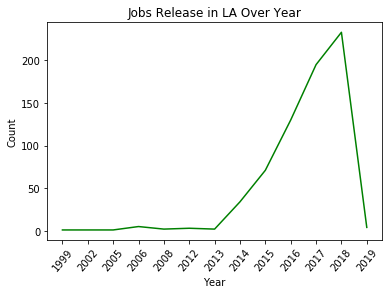

In [28]:
# Extract features
job_date = final_df[["FILE_NAME","JOB_CLASS_TITLE","YEAR","MONTH","DAY_OF_WEEK"]].drop_duplicates()
# Check job release count by year
year = job_date['YEAR'].value_counts().sort_index().index.astype('str') # change index type to str for ploting
count = job_date['YEAR'].value_counts().sort_index().values
plt.plot(year, count, color='g')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Jobs Release in LA Over Year')
plt.xticks(rotation=50)
plt.show()

It seems that job oppertunities starting to grow since then 2014, or a more likely explaination is that data records have been better preserved after 2014, since unlikely that there is nearly no hiring before 2013.

#### Does Job openings have a monthly preference?

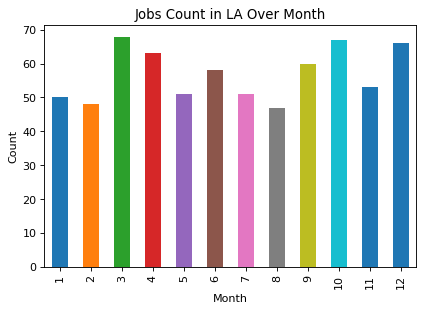

In [29]:
# Check job release count by month
figure(num=None, figsize=(6, 4), dpi=80) # Set figure size
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Jobs Count in LA Over Month')
job_date['MONTH'].value_counts().sort_index().plot(kind='bar')
plt.show()

Possibly we have more job openings in March, April, October and December. Less opertunity in January, Febuary, May, July and Augest. 

#### Or maybe a weekday preference?

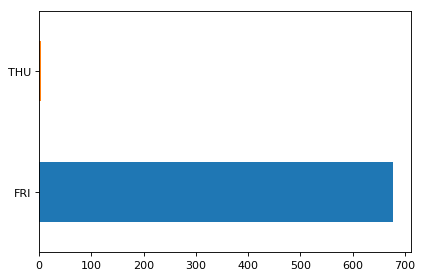

In [30]:
# Check job release count by weekday
figure(num=None, figsize=(6, 4), dpi=80) # Set figure size
job_date['DAY_OF_WEEK'].value_counts().plot(kind='barh')
plt.show()

In [31]:
# What are the jobs open on thursday?
job_date[job_date['DAY_OF_WEEK']=='THU'][['JOB_CLASS_TITLE']]

,JOB_CLASS_TITLE
32,Airport Police Officer
692,Police Officer
699,Police Specialist
715,Port Police Officer


Pretty solid that almost all jobs are opened on Friday, except four of those, which are "police" related jobs!

#### What's the salary distribution in LA city?

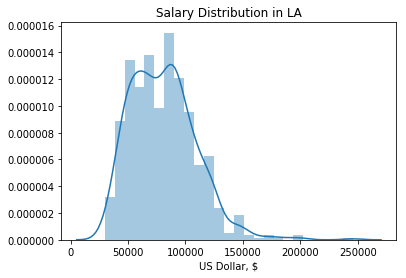

The average starting salary is $80630. The std is 28335.


In [32]:
# Generate a focus dataframe with the feature of interest
sal = final_df[['FILE_NAME','JOB_CLASS_TITLE','ENTRY_SALARY_GEN', 'SAL_DIF', 'MIN_SAL']].drop_duplicates().dropna()
sal = sal.drop('FILE_NAME', axis=1)
# Plot distribution historgram
sns.distplot(sal['MIN_SAL'],bins=25)
#plt.hist(sal['MIN_SAL'], color = 'indianred', bins=25)
plt.xlabel('US Dollar, $')
plt.title('Salary Distribution in LA')
plt.show()
print(f"The average starting salary is ${int(sal['MIN_SAL'].mean())}. The std is {int(sal['MIN_SAL'].std())}.")

Looks like normal distribution in general.

#### What are the 15 best jobs?

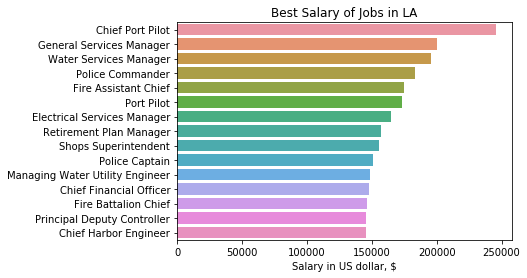

In [33]:
best15 = sal[['JOB_CLASS_TITLE','MIN_SAL']].sort_values('MIN_SAL', ascending = False)[:15]
sns.barplot(y=best15['JOB_CLASS_TITLE'],x=best15['MIN_SAL'])
plt.xlabel('Salary in US dollar, $')
plt.ylabel('')
plt.title('Best Salary of Jobs in LA')
plt.show()

Not surprise, "Leader" or "Manager" levels positions and polits.

#### What job has the biggest salary difference in percentage?

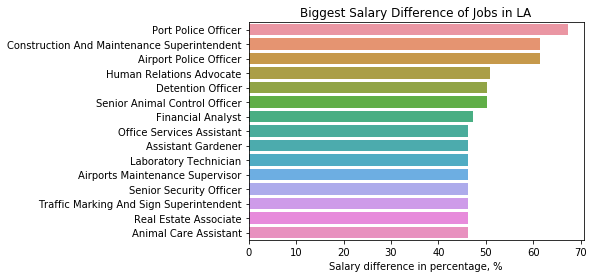

,JOB_CLASS_TITLE,SAL_DIF,MIN_SAL,PERC_DIF
715,Port Police Officer,32761.0,48713.0,67.253095


In [34]:
big_dif = sal[['JOB_CLASS_TITLE','SAL_DIF', 'MIN_SAL']]
big_dif['PERC_DIF'] = [ int(x)/int(y)*100 for x,y in zip(big_dif['SAL_DIF'], big_dif['MIN_SAL'])]
big_dif = big_dif.sort_values('PERC_DIF', ascending = False)[:15]
sns.barplot(y=big_dif['JOB_CLASS_TITLE'],x=big_dif['PERC_DIF'])
plt.xlabel('Salary difference in percentage, %')
plt.ylabel('')
plt.title('Biggest Salary Difference of Jobs in LA')
plt.show()
big_dif[:1]

Some Port Police Officer might have up to 1.67 time salary than the starting colleagues. 

#### Is there a preference of exam type?

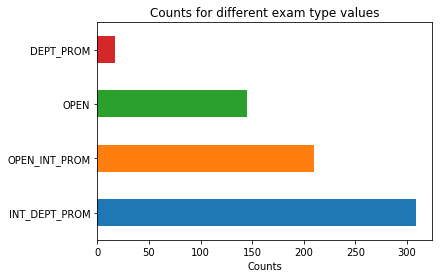

In [35]:
# Get data from the database (df)
promo_type = final_df[['FILE_NAME','JOB_CLASS_TITLE','EXAM_TYPE', 'MIN_SAL']].drop_duplicates().dropna()
# Check job release count by weekday
promo_type['EXAM_TYPE'].value_counts().plot(kind='barh')
plt.xlabel('Counts')
plt.title('Counts for different exam type values')
plt.show()

In [36]:
depart = promo_type[promo_type['EXAM_TYPE']=="DEPT_PROM"].drop(['FILE_NAME'], axis=1)
depart

,JOB_CLASS_TITLE,EXAM_TYPE,MIN_SAL
30,Airport Police Captain,DEPT_PROM,142568.0
51,Apparatus Operator,DEPT_PROM,93792.0
429,Engineer Of Fire Department,DEPT_PROM,91955.0
473,Fire Assistant Chief,DEPT_PROM,175141.0
476,Fire Battalion Chief,DEPT_PROM,145909.0
479,Fire Captain,DEPT_PROM,119016.0
480,Fire Helicopter Pilot,DEPT_PROM,88426.0
481,Fire Inspector,DEPT_PROM,102520.0
490,Fireboat Mate,DEPT_PROM,88426.0
491,Fireboat Pilot,DEPT_PROM,109974.0


Looks like "police" or "fire" related department prefer departmental promotional.

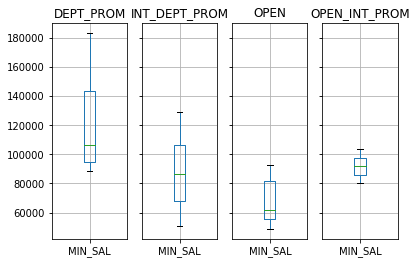

In [37]:
# Check all job class titles include the word "poice" and "fire" 
police_and_fire = []
for x in promo_type.index:
    if 'police' in promo_type.loc[x][1].lower() or 'fire' in promo_type.loc[x][1].lower():
        police_and_fire.append(promo_type.loc[x])
        
police_and_fire = DataFrame(police_and_fire).drop('FILE_NAME',axis=1).sort_values('MIN_SAL', ascending = False)
police_and_fire.head()

police_and_fire.groupby('EXAM_TYPE').boxplot(layout=(1,4))
plt.show()

In "police" or "fire" related deparment, departmental exam type promotional leads to a higher salary position.

#### How many jobs mentioned additional license in the job bulletin? What's the salary difference of those jobs?

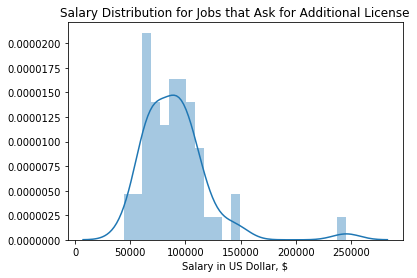

The average starting salary for jobs that ask for additinoal license is $90537.
It's $9907 more than the overall average.
53 jobs mentioned additional license (not including driver's license), it's 7.8% of the job pool


In [38]:
# Create dataframe from extracting rows that have values in column ADDTL_LIC
addtl_df = final_df[['FILE_NAME','JOB_CLASS_TITLE' ,'ADDTL_LIC','MIN_SAL']][final_df['ADDTL_LIC'].notnull()].drop_duplicates()
# Plot salary distribution
sns.distplot(addtl_df['MIN_SAL'],bins=25)
#plt.hist(addtl_df['MIN_SAL'], color = 'indianred', bins=10)
plt.xlabel('Salary in US Dollar, $')
plt.xticks(rotation=0)
plt.title('Salary Distribution for Jobs that Ask for Additional License')
plt.show()
print(f"The average starting salary for jobs that ask for additinoal license is ${int(addtl_df['MIN_SAL'].mean())}.")
print(f"It's ${int(addtl_df['MIN_SAL'].mean()-total_avg_sal)} more than the overall average.")
print(f"{addtl_df.shape[0]} jobs mentioned additional license (not including driver's license), it's {round(addtl_df.shape[0]/total_job_count,3)*100}% of the job pool")

#### How many jobs mentioned a valid driver's license? What about the types?

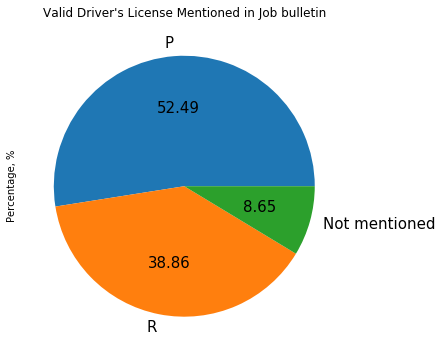

In [39]:
driv_df = final_df[['FILE_NAME','DRIVERS_LICENSE_REQ']].drop_duplicates().drop("FILE_NAME", axis=1)
driv_df['DRIVERS_LICENSE_REQ'].replace(np.nan,'Not mentioned').value_counts().plot.pie(autopct='%.2f', fontsize=15, figsize=(6, 6))
plt.ylabel('Percentage, %')
plt.title("Valid Driver's License Mentioned in Job bulletin")
plt.show()

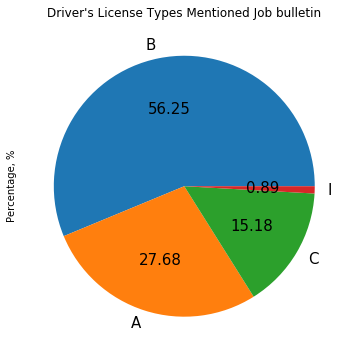

In [40]:
drivtype_df = final_df[['FILE_NAME','DRIV_LIC_TYPE']].drop_duplicates().drop("FILE_NAME", axis=1)
type_list = []
for x in drivtype_df['DRIV_LIC_TYPE'].dropna():
    type_list += x.split("|")
counter=Counter(type_list)
Series(counter).plot.pie(autopct='%.2f', fontsize=15, figsize=(6, 6))
plt.ylabel('Percentage, %')
plt.title("Driver's License Types Mentioned Job bulletin")
plt.show()

Over 80% of jobs mentioned driver's license, an type B is the most common one if specified.

#### How many jobs ask for course units to be taken in the requirements? What are the most popular ones they are looking for?

In [41]:
# Drop rows that have all null values in the following three columns: COURSE_COUNT, COURSE_LENGTH,COURSE_SUBJECT
course_df = final_df.loc[final_df[['COURSE_COUNT','COURSE_LENGTH','COURSE_SUBJECT']].dropna(how='all').index]
# Extract the features of interest
course_df = course_df[['FILE_NAME','JOB_CLASS_TITLE','COURSE_COUNT','COURSE_LENGTH','COURSE_SUBJECT']]
course_cnt = len(course_df['FILE_NAME'].unique())
print(f"{course_cnt} jobs ask for specific course unit to be taken in the requirement. This is {round(course_cnt/total_job_count,4)*100}% of the job pool.")

80 jobs ask for specific course unit to be taken in the requirement. This is 11.73% of the job pool.


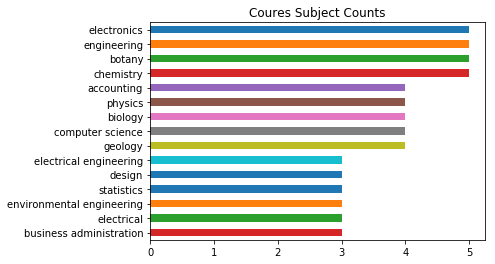

In [42]:
# Count all course subjects
temp = course_df[['COURSE_SUBJECT','FILE_NAME']].drop_duplicates()
course_list = []
for x in temp['COURSE_SUBJECT'].dropna():
    course_list += x.lower().split("|")
course_list

Series(Counter(course_list)).sort_values(ascending=False)[:15].plot(kind='barh')
plt.title("Coures Subject Counts")
plt.gca().invert_yaxis()

#### How many jobs ask for previous job experience and the experience length?

In [43]:
# Drop rows that have all null values in experience columns
exp_df = final_df.loc[final_df[['EXPERIENCE_LENGTH','FULL_TIME_PART_TIME','EXP_JOB_CLASS_TITLE','EXP_JOB_CLASS_ALT_RESP']].dropna(how='all').index]
# Grab the feature of interest
focus_columns = ['FILE_NAME','JOB_CLASS_TITLE','EXPERIENCE_LENGTH', 'FULL_TIME_PART_TIME',
                 'EXP_JOB_CLASS_TITLE','EXP_JOB_CLASS_ALT_RESP','EXP_JOB_CLASS_FUNCTION']
exp_df = exp_df[focus_columns]
exp_cnt = len(exp_df['FILE_NAME'].unique())

print(f"{exp_cnt} jobs mentioned previous job experience. this is {round(exp_cnt/total_job_count,4)*100}% of the job pool.")

615 jobs mentioned previous job experience. this is 90.18% of the job pool.


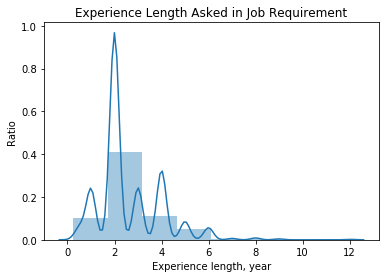

The average of experience length per requirement set is 2.6 year.


In [44]:
# Plot experience length distribution
exp_leng = exp_df['EXPERIENCE_LENGTH'].dropna()#.value_counts().sort_index()
exp_leng_avg = exp_leng.mean()
sns.distplot(list(exp_leng.values),bins=8)
plt.xlabel('Experience length, year')
plt.ylabel('Ratio')
plt.title('Experience Length Asked in Job Requirement')
plt.show()
print(f"The average of experience length per requirement set is {round(exp_leng_avg,2)} year.")

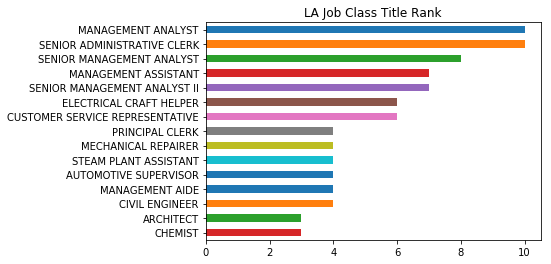

In [45]:
position_list = []
# We want one count of EXP_JOB_CLASS_TITLE for each job, so drop duplicates
position_df =  exp_df[['FILE_NAME','EXP_JOB_CLASS_TITLE']].drop_duplicates()
for x in position_df['EXP_JOB_CLASS_TITLE'].dropna():
    position_list += x.split('|')

Series(Counter(position_list)).sort_values(ascending = False)[:15].plot(kind='barh')
plt.title("LA Job Class Title Rank")
plt.gca().invert_yaxis()

Almost all jobs prefer applicants with job experience, most of those ask for at least two yearsof expereience. "Analyst" and "Management" are most frequently asked.

#### What the most popular school type mentioned in the job bullettin?

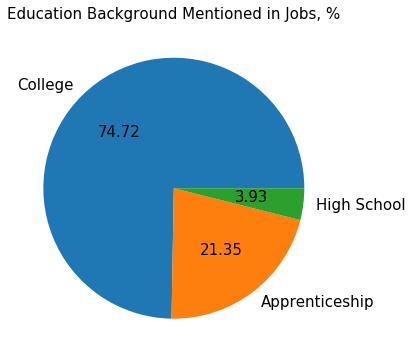

In [46]:
# Generate a dataframe with feartures of interest, drop rows with null value in SCHOOL_TYPE
focus_colum = ['FILE_NAME','JOB_CLASS_TITLE','EDUCATION_YEARS','SCHOOL_TYPE','EDUCATION_MAJOR','EXPERIENCE_LENGTH',
               'EXP_JOB_CLASS_TITLE', 'EXP_JOB_CLASS_ALT_RESP','DRIVERS_LICENSE_REQ','ADDTL_LIC', 'MIN_SAL', 'YEAR', 'MONTH']
edu_df = final_df[focus_colum][final_df['SCHOOL_TYPE'].notnull()]
# Count the jobs that ask for apprenticeship, college and high school diploma
edu_cnt = len(edu_df['FILE_NAME'].unique())
appren_cnt = len(edu_df[edu_df['SCHOOL_TYPE']=='APPRENTICESHIP']['FILE_NAME'].unique())
high_cnt = len(edu_df[edu_df['SCHOOL_TYPE']=='HIGH SCHOOL']['FILE_NAME'].unique())
college_cnt = len(edu_df[edu_df['SCHOOL_TYPE']=='COLLEGE OR UNIVERSITY']['FILE_NAME'].unique())
Series({"College":college_cnt,"Apprenticeship":appren_cnt, "High School":high_cnt}).plot.pie(autopct='%.2f', fontsize=15, figsize=(6, 6))
plt.ylabel("")
plt.title("Education Background Mentioned in Jobs, %", fontsize=15)
plt.show()

Most of them ask for college degree if mentioned.

#### What are the chances for ones that only have high school diploma?

In [47]:
high_cnt = len(edu_df[edu_df['SCHOOL_TYPE']=='HIGH SCHOOL'])
print(f"Among {total_job_count} jobs, {high_cnt} jobs only ask for high school diploma.")
print(f"The portion is {round(high_cnt/total_job_count,4)*100}% of the job pool.")
high_df = edu_df[edu_df['SCHOOL_TYPE']=='HIGH SCHOOL'][['JOB_CLASS_TITLE','SCHOOL_TYPE','EXPERIENCE_LENGTH','DRIVERS_LICENSE_REQ','MIN_SAL']].sort_values('MIN_SAL', ascending=False)
print(f"The best payment among those position is ${high_df['MIN_SAL'].max()}. The salary average is ${round(high_df['MIN_SAL'].mean(),2)}.")
high_df   

Among 682 jobs, 7 jobs only ask for high school diploma.
The portion is 1.03% of the job pool.
The best payment among those position is $69008.0. The salary average is $51418.29.


,JOB_CLASS_TITLE,SCHOOL_TYPE,EXPERIENCE_LENGTH,DRIVERS_LICENSE_REQ,MIN_SAL
493,Firefighter,HIGH SCHOOL,NaN,R,69008.0
692,Police Officer,HIGH SCHOOL,NaN,R,57420.0
32,Airport Police Officer,HIGH SCHOOL,NaN,R,51448.0
715,Port Police Officer,HIGH SCHOOL,NaN,R,48713.0
315,Detention Officer,HIGH SCHOOL,0.5,R,46625.0
1070,Traffic Officer,HIGH SCHOOL,1.0,R,45017.0
270,Communications Information Representative,HIGH SCHOOL,1.0,NaN,41697.0


Best payment jobs for applicants that only have high school diploma are Firefighter and Police Officer. Most of those position required a valid driver's license.

#### What about chances for apprenticeship?

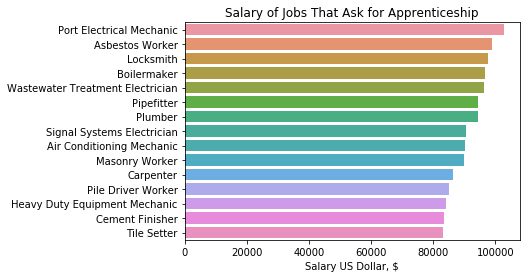

Among 682 jobs, 38 of those ask for apprenticeship.
The portion is 5.57% of the job pool.
The average salary is $82411.95.


In [48]:
# Get more specialized worker list by searching apprenticeship value
specilized_worker = set()
appren_df = edu_df[edu_df['SCHOOL_TYPE']=='APPRENTICESHIP'][["FILE_NAME","JOB_CLASS_TITLE",'MIN_SAL']].drop_duplicates()
appren_cnt = len(appren_df)
appren_sal = appren_df['MIN_SAL'].mean()
for role in appren_df:
    specilized_worker.add(role.split(" ")[-1])

# Plot
appren_df = appren_df.sort_values('MIN_SAL', ascending = False)[:15]
sns.barplot(y=appren_df['JOB_CLASS_TITLE'],x=appren_df['MIN_SAL'])
plt.xlabel('Salary US Dollar, $')
plt.ylabel('')
plt.title('Salary of Jobs That Ask for Apprenticeship')
plt.show()
print(f"Among {total_job_count} jobs, {appren_cnt} of those ask for apprenticeship.")
print(f"The portion is {round(appren_cnt/total_job_count,4)*100}% of the job pool.")
print(f"The average salary is ${round(appren_sal,2)}.")

#### How about chances for students who have college degree but with no work experience?

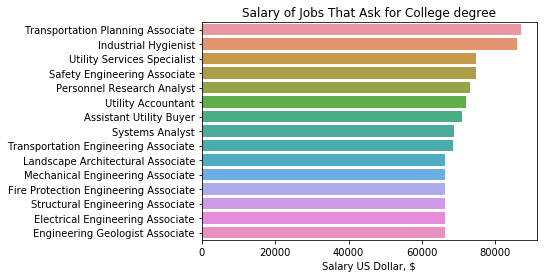

Among 682 jobs, 45 of those accepts college degree applicants with job experience.
The portion is 6.6000000000000005% of the job pool.
The average salary is $62725.47.


In [49]:
# Find all jobs that didn't required job expereience
focus_columns = ['FILE_NAME','JOB_CLASS_TITLE','MIN_SAL',"MONTH"]
college_no_exp_df = edu_df[edu_df["EXPERIENCE_LENGTH"].isnull()]
college_no_exp_df = college_no_exp_df[college_no_exp_df["EXP_JOB_CLASS_TITLE"].isnull()]
college_no_exp_df = college_no_exp_df[college_no_exp_df["SCHOOL_TYPE"]=='COLLEGE OR UNIVERSITY']
job_no_exp = college_no_exp_df[focus_columns].drop_duplicates().drop("FILE_NAME",axis=1).sort_values("MIN_SAL", ascending=False)
# Plot
sns.barplot(y=job_no_exp[:15]['JOB_CLASS_TITLE'],x=job_no_exp[:15]['MIN_SAL'])
plt.xlabel('Salary US Dollar, $')
plt.ylabel('')
plt.title('Salary of Jobs That Ask for College degree')
plt.show()
no_exp_cnt = len(job_no_exp)
no_exp_sal = job_no_exp['MIN_SAL'].mean()
print(f"Among {total_job_count} jobs, {no_exp_cnt} of those accepts college degree applicants with job experience.")
print(f"The portion is {round(no_exp_cnt/total_job_count,4)*100}% of the job pool.")
print(f"The average salary is ${round(no_exp_sal,2)}.")

#### Last question for interest, if we try to group all job titles into three level by hierarchy, what are the changes over the past few years?

I group job hierarchy by searching key words in the job title such as:
- Top level: "Director of", "Chief", "Principal", "Specialist", "Executive", "Captain", "Superintendent", "Curator", "Manager", "Division", "Engineer of", "Commander".
- Middle level: "Senior", "Supervisor", "Sergeant", "Lieutenant", "Analyst", "Dispatcher", "Instructor", "Director", "Administrator", "Detective".
- Entry levle: Else.

In [50]:
job_level = final_df[['FILE_NAME','JOB_CLASS_TITLE','MIN_SAL','YEAR']].drop_duplicates()

top_words = ["director of", "chief", "principal","specialist", "executive", "captain",
         "superintendent", "curator", "manager", "division","engineer of", "commander"]
mid_words = ["senior","supervisor","sergeant","lieutenant","analyst","dispatcher","instructor",
             "director","administrator", "detective"]
job_level = job_level.reset_index()
k = 0
for x in job_level["JOB_CLASS_TITLE"]:  
    if any(word in x.lower() for word in top_words):
        job_level.at[k,'JOB_LV'] = "T"
    elif any(word in x.lower() for word in mid_words):
        job_level.at[k,'JOB_LV'] = "M"
    else:
        job_level.at[k,'JOB_LV'] = "E"
    k+=1
job_level = job_level[["JOB_LV","MIN_SAL","YEAR"]]
# Higher job level normaly should have higher grade, so we check if the average salary make sense
job_level[["JOB_LV","MIN_SAL"]].groupby("JOB_LV").mean()

,MIN_SAL
JOB_LV,
E,67999.511706
M,84126.672897
T,98657.732143


The method probably work, because conventionally average starting salary should be like: top level > middle > entry level.

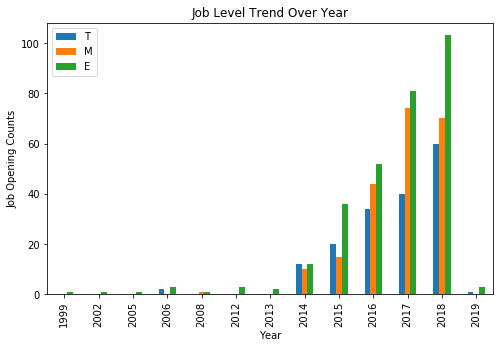

In [51]:
# Plot the amount of job level trend over year
temp_dict = {}
for grade in ["T","M","E"]:
    temp = job_level[job_level['JOB_LV']==grade]
    temp_dict[grade] = temp["YEAR"].value_counts()
DataFrame(temp_dict).plot.bar(figsize=(8,5))
plt.xlabel('Year')
plt.ylabel('Job Opening Counts')
plt.title('Job Level Trend Over Year')
plt.show()

We got normal structure after 2016, that is, opportunity for manager level are less than senior level and senior level are less than entry level. If not normal then if might indicates problem such as high job turnover rate. 

## Text analysis for recommandation
In this project we are ask to:
1.  identify language that can negatively bias the pool of applicants; 
2.  improve the diversity and quality of the applicant pool; and/or 
3.  make it easier to determine which promotions are available to employees in each job class.

### Identify language that can negatively bias the pool of applicants
To identify language that can negatively bias the pool of applicants, we will first need a list of words that is to be considered as "bias" words, thus the following website provides us what we want:

http://gender-decoder.katmatfield.com/about

For the following analysis, we are only going to count bias words in locate in the job duty and requirement section.

In [52]:
bias_words = set()
t='''
agree
affectionate
child
cheer
collab
commit
communal
compassion
connect
considerate
cooperat
co-operat
depend
emotiona
empath
feel
flatterable
gentle
honest
interpersonal
interdependen
interpersona
inter-personal
inter-dependen
inter-persona
kind
kinship
loyal
modesty
nag
nurtur
pleasant
polite
quiet
respon
sensitiv
submissive
support
sympath
tender
together
trust
understand
warm
whin
enthusias
inclusive
yield
share
sharin
active
adventurous
aggress
ambitio
analy
assert
athlet
autonom
battle
boast
challeng
champion
compet
confident
courag
decid
decision
decisive
defend
determin
domina
dominant
driven
fearless
fight
force
greedy
head-strong
headstrong
hierarch
hostil
impulsive
independen
individual
intellect
lead
logic
objective
opinion
outspoken
persist
principle
reckless
self-confiden
self-relian
self-sufficien
selfconfiden
selfrelian
selfsufficien
stubborn
superior
unreasonab'''
pattern = re.compile(r"[a-z-]+").findall(t)
for n in pattern:
    bias_words.add(" "+n) # word should be a the starting characters

print(f"We got {len(bias_words)} bias words in our list!")

We got 102 bias words in our list!


In [53]:
bias_check_df = DataFrame()
i = 0
total_cnt_list = [] # hold all bias word encountered
for file in bulletins:
    with open("Job Bulletins/"+file) as f:
        try:
            text = f.read()
            # Extract job duty content
            duty = re.compile(r"DUT[A-Z ]+\s+(.+)\n").search(text)
            if duty:
                duty_text = duty.group(1)
            else:
                continue
            
            # Extract requirement content
            req = re.compile(r'(REQUIREMENT[A-Z /:]*)\n((.|\n)+?)\n\s*([A-Z ]*NOTE|\n[A-Z]{4})').search(text)
            if req:
                req_text = req.group(2)
            else: 
                continue
            
            # Put two content together
            text = duty_text + req_text
            
            bias_check_df.at[i, "FILE_NAME"] = file
            bias_w_cnt = 0 # count the number of all bias word in a text file
            bias_record = [] # record the bias words 
            
            for word in bias_words:
                pattern = re.compile(word+"[a-z]*").findall(text)
                for t in pattern:
                    bias_w_cnt+=1
                    bias_record.append(t)
                    total_cnt_list.append(t)
            bias_check_df.at[i, "BIAS_COUNT"] = bias_w_cnt
            bias_check_df.at[i, "BIAS_WORDS"] = "|".join(list(set(bias_record)))
        except:
            pass
        i+=1
counter = Counter(total_cnt_list)

In [54]:
bias_check_df.head()

,FILE_NAME,BIAS_COUNT,BIAS_WORDS
0,311 DIRECTOR 9206 041814.txt,4.0,principles| responsible| responsibilities| force
1,ACCOUNTANT 1513 062218.txt,2.0,principles| analysis
2,ACCOUNTING CLERK 1223 071318.txt,2.0,responsible| lead
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,2.0,force| responsibilities
4,ADMINISTRATIVE ANALYST 1590 060118.txt,8.0,analysis


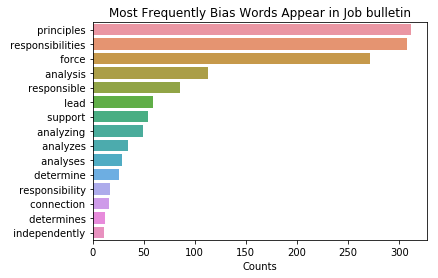

In [55]:
Series(counter).sort_values(ascending=False)
# Plot
bias_rank = Series(counter).sort_values(ascending=False)[:15]
sns.barplot(y=bias_rank.index,x=bias_rank.values)
plt.xlabel('Counts')
plt.ylabel('')
plt.title('Most Frequently Bias Words Appear in Job bulletin')
plt.show()

In [56]:
bias_check_df.sort_values("BIAS_COUNT", ascending=False)[:15]

,FILE_NAME,BIAS_COUNT,BIAS_WORDS
211,EMERGENCY MANAGEMENT COORDINATOR 1702 102618.txt,12.0,analyzing| analyzes| response| responsible| i...
551,SENIOR UTILITY SERVICES SPECIALIST 3753 121815...,9.0,analyzing| responsibilities| supporting| supp...
248,FISCAL SYSTEMS SPECIALIST 1555 101918.txt,9.0,analyses| supportive| analyzes| responsibilit...
100,CHIEF ADMINISTRATIVE ANALYST 1554 062416.txt,9.0,committees| responsibilities| principles| for...
360,POLICE ADMINISTRATOR 9196 100617.txt,9.0,responsibilities| support| principles| force|...
550,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,9.0,analyzing| responsibilities| supporting| supp...
508,SENIOR HOUSING INVESTIGATOR 8517 020317 REVISE...,9.0,analyzing| lead| responsibilities| support| p...
4,ADMINISTRATIVE ANALYST 1590 060118.txt,8.0,analysis
635,UTILITY SERVICES SPECIALIST 3755 072117 (1).txt,8.0,analyses| individual| analyzes| lead
634,UTILITY SERVICES MANAGER 9106 110416.txt,8.0,analyzing| responsibilities| analytics| suppo...


### Readability test
- Score	Difficulty
- 90-100	Very Easy
- 80-89	Easy
- 70-79	Fairly Easy
- 60-69	Standard
- 50-59	Fairly Difficult
- 30-49	Difficult
- 0-29	Very Confusing

In [57]:
read_df = DataFrame()
i = 0
for file in bulletins:
    with open("Job Bulletins/"+file,encoding="ISO-8859-1") as f:
        try:
            text = f.read()

            read_df.at[i,"FILE_NAME"] = file
            num_sen = text.count('.') + text.count('!') + text.count(';') + text.count(':') + text.count('?')

            asl = len(text.split())/num_sen
            syl_cnt = 0
            for word in text.split():
                for vowel in ['a','e','i','o','u']:
                    syl_cnt += word.count(vowel)
                for ending in ['es','ed','e']:
                    if word.endswith(ending):
                           syl_cnt -= 1
                if word.endswith('le'):
                    syl_cnt += 1
                
            asw = syl_cnt/len(text.split())
            score = 206.835-(1.015*asl)-(84.6*asw)
            read_df.at[i,"F_SCORE"] = score
        except:
            pass
    i+=1


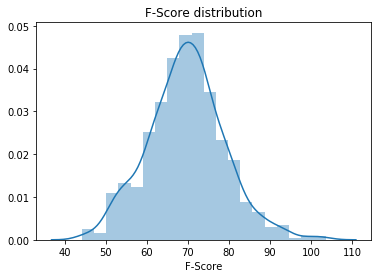

The average F-score is 69.57. Std is 9.36.


In [58]:
# Plot distribution
sns.distplot(read_df["F_SCORE"],bins=20)
plt.xlabel('F-Score')
plt.ylabel('')
plt.title('F-Score distribution')
plt.show()
r_mean = read_df["F_SCORE"].mean()
r_std = read_df["F_SCORE"].std()
print(f"The average F-score is {round(r_mean,2)}. Std is {round(r_std,2)}.")

### Determine which promotions are available to employees in each job class
If the previous output data set (variable name: df) is well built then we can simply search that data set. Search column EXP_JOB_CLASS_TITLE and EXP_JOB_CLASS_ALT_RESP for a certain job class to see which promotions are avialable to it. 

Let's first see a general list for job classes that could be promoted.

In [59]:
def get_all_promotions(dataset=df):
    '''
    Takes a pandas DataFrame. Returns a set of job class titles.
    **Notice**
    DataFrame, need to include column EXP_JOB_CLASS_TITLE with data type object (string).
    '''
    promo_list = []
    job_ser = dataset["EXP_JOB_CLASS_TITLE"].dropna()
    for title in job_ser:
        promo_list += title.split("|")

    return set(promo_list)

In [60]:
print(f"Total of {len(get_all_promotions())} job titles have opportunities to be promoted.")

Total of 368 job titles have opportunities to be promoted.


In [61]:
# Unmark to see the result
# get_all_promotions()

Now we want to know which promotions are available to employees in each job class. The following funciton help us get the result in the dataframe.

In [62]:
def promotion_search(job_class, dataset=df, vague=False):
    '''
    Take in a job class (string), a DataFrame, vague (boolean). Returns rows in the dataframe that match 
    the promotion for that job class. 
    
    **Notice**
    Dataset need to have a column name EXP_JOB_CLASS_TITLE and EXP_JOB_CLASS_ALT_RESP 
    with a data type of string (object).
    
    Parameters:
    job_class, string data type, upper or lowercase. e.g, engineer, management analyst, etc.
    dataset, pandas DataFrame data type, the default is set to the dataframe built previously.
    vague, boolean data type, determines whether it should do a vague search or not. 
    For example:
    1. job_class = "senior management analyst", vague=False. 
        Only search column EXP_JOB_CLASS_TITLE, returns any row that include "senior management analyst".
    2. job_class = "software engineer", vague=True.
        Search columns EXP_JOB_CLASS_TITLE and EXP_JOB_CLASS_ALT_RESP, return any row that include 
        "software engineer" in the two columns.

    '''
    
    try:
        if vague:
            # Search column EXP_JOB_CLASS_TITLE
            ret1 = dataset[dataset['EXP_JOB_CLASS_TITLE'].notnull()]
            ret1 = ret1[ret1['EXP_JOB_CLASS_TITLE'].str.contains(job_class.upper())]
            # Search column EXP_JOB_CLASS_ALT_RESP
            ret2 = dataset[dataset['EXP_JOB_CLASS_ALT_RESP'].notnull()]
            ret2 = ret2[ret2['EXP_JOB_CLASS_ALT_RESP'].str.contains(job_class.lower())]
            
            return pd.concat([ret1,ret2]) # Add both result together
            
        else:
            ret = dataset[dataset['EXP_JOB_CLASS_TITLE'].notnull()]
            return ret[ret['EXP_JOB_CLASS_TITLE'].str.contains(job_class.upper())]
    except:
        print("Invalid argument for promotion search!")

In [63]:
# Function return match rows in dataframe, let's just present some particular columns 
# and show only the first five results 
promotion_search("management analyst")[["JOB_CLASS_TITLE","EXP_JOB_CLASS_TITLE"]].head()

,JOB_CLASS_TITLE,EXP_JOB_CLASS_TITLE
0,311 Director,SENIOR MANAGEMENT ANALYST
97,Assistant Airport Manager,SENIOR MANAGEMENT ANALYST
118,Assistant Retirement Plan Manager,SENIOR MANAGEMENT ANALYST II
202,Chief Benefits Analyst,SENIOR MANAGEMENT ANALYST
223,Chief Management Analyst,SENIOR ADMINISTRATIVE ANALYST II|SENIOR MANAGE...


In [64]:
# If we want to know opportunities for all job class and alternative class,
# we could do vague search.
promotion_search("architect", vague=True)[["JOB_CLASS_TITLE","EXP_JOB_CLASS_TITLE","EXP_JOB_CLASS_ALT_RESP"]]

,JOB_CLASS_TITLE,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP
69,Architect,ARCHITECTURAL ASSOCIATE II,NaN
292,Contract Administrator,LANDSCAPE ARCHITECT|ARCHITECT,NaN
293,Contract Administrator,ARCHITECTURAL ASSOCIATE IV|LANDSCAPE ARCHITECT...,NaN
521,Harbor Engineer,ARCHITECT|CIVIL ENGINEER,NaN
577,Landscape Architect,LANDSCAPE ARCHITECTURAL ASSOCIATE II,NaN
730,Principal Civil Engineering Drafting Technician,SENIOR CIVIL ENGINEERING DRAFTING TECHNICIAN|S...,NaN
805,Rehabilitation Construction Specialist,ARCHITECTURAL ASSOCIATE,NaN
858,Senior Architect,ARCHITECT,NaN
859,Senior Architectural Drafting Technician,ARCHITECTURAL DRAFTING TECHNICIAN,NaN
311,Database Architect,SENIOR SYSTEMS ANALYST I|PROGRAMMER ANALYST IV...,database administrator|database architect


## Summary & Recommendation

1. **Identify language that can negatively bias the pool of applicants:** search the job description and reaplace all "bias" words if possible. A "bias" word list could be found on the internet and/or keep on updating a self-kept list. In this notebook we demostrate a rank of "bias" words found in 683 job bulletin text files, these bias words could either be masculine-coded or feminine-coded according to the website http://gender-decoder.katmatfield.com/about. The advatage of the method we use here is easy, we just simply search all "bias" words in all files and maintain a "bias" word list. The biggest disadvantage is that it may not be totally accurate, so following manual inspection is required. For example, in the result shown previously, "principles" is the most common word found in all files, but it is in fact often included in course subjects names. Nevertheless, this method could work as a filter for detecting possible bias languages in job descriptions. 


2. **Improve the diversity and quality of the applicant pool:** 
    * Identify and replacing "bias" words could imporve diversity and quality of the applicant pool, since some "bais" words many deter talent or potential applicants from applying the job. 
    * Some articles have pointed out that improving readability may improve the diversity of the applicant pool for some positions don't highly depend on readability, thus complex job decription might push away those acturally qualified applicants. In this notebook we demostrate using Flesch Score to test readabiity for all text files, but we are leaving the decision of what should be the proper readability level required for a position to the employer (unless we got a readability survey data for each positions).  


3. **Make it easier to determine which promotions are available to employees in each job class:** This is going to be easy if we parse all text files into the final output data set correctly. Because each row in the output data set is a minimun requirement set for a position, hence for any job class appeared in EXP_JOB_CLASS_TITLE, there is a opportunity for that job class to be promoted. Here, we demostate the result by writing a function **promotion_search("job_class_name")**, where we can pass is a job class name and it will return a dataframe with all job openings that match. We could also use **get_all_promotions()** to get a set of all potential job classes for promotion.  

-----

End of notebook, thanks for reading!